# Configuracao e inicializacao spark

In [1]:
import pyspark.sql.functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import findspark
findspark.init()

from pyspark.sql import SparkSession

from pyspark.sql.window import Window
from pyspark.ml.stat import Correlation, ChiSquareTest
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.types import DecimalType

In [2]:
spark = (
    SparkSession.builder
    .appName("datamaster_case_gustavo")
    # Usar todos os cores locais disponíveis;
    .master("local[*]")
    # memória do driver (~70% da RAM total)
    .config("spark.driver.memory", "20g")
    # tamanho de partição padrão (OBS: ajustar depois baseado no tamanho final)
    .config("spark.sql.shuffle.partitions", "200")
    # compressão em disco
    .config("spark.sql.parquet.compression.codec", "snappy")
    # para evitar broadcast grande nos joins
    .config("spark.sql.autoBroadcastJoinThreshold", "50MB")
    .getOrCreate()
)

In [3]:
base_path = r"C:\Users\Gustavo\Downloads\datamaster\dados\parquet"  # ajuste para o seu caminho

df_logs = spark.read.parquet(f"{base_path}/user_logs.parquet")
df_transactions   = spark.read.parquet(f"{base_path}/transactions.parquet")
df_members  = spark.read.parquet(f"{base_path}/members.parquet")

# Funcoes Utilizadas

In [4]:
def verificar_duplicatas(df, col_id="msno", col_safra="safra", visualizar=False):
    """
    Identifica e conta linhas duplicadas para a mesma chave (ID + Safra).
    """
    # Define a janela abrangendo todas as linhas do grupo
    window_spec = Window.partitionBy(col_id, col_safra)\
                        .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    
    # Adiciona contagem e filtra duplicados
    df_duplicados = df.withColumn("contagem_janela", F.count("*").over(window_spec)).filter("contagem_janela > 1")
    
    if visualizar:
        df_duplicados.show(10)
    
    # Retorna a quantidade total de linhas duplicadas encontradas
    return df_duplicados.count()

In [5]:
def verificar_mudanca_estado(df, col_alvo, col_id="msno", col_safra="safra", visualizar=False):
    """
    Verifica mudanças de estado em uma variável ao longo do tempo (safras).
    """
    # Definir a especificação da janela
    window_spec = Window.partitionBy(col_id).orderBy(col_safra)

    # Lag para criar as colunas de estado anterior da variavel e detecção de mudança
    df_historico = (
        df.withColumn(f"{col_alvo}_anterior", F.lag(col_alvo).over(window_spec))
          .withColumn("mudou", 
              F.when(F.col(f"{col_alvo}_anterior").isNull(), False)
               .otherwise(F.col(col_alvo) != F.col(f"{col_alvo}_anterior"))))

    # Caso o usuario deseje visualizar as mudancas
    if visualizar:
        # Mostrar quantas mudancas ocorreram por safra
        print("Contagem de mudanças por safra:")
        df_historico.filter(F.col("mudou") == True).groupBy(col_safra, "mudou").count().orderBy(col_safra, "mudou").show(30, truncate=False)
        # Mostrar quantas vezes o usuario mudou
        print("Mudanças por usuário:")
        df_historico.filter(F.col("mudou") == True).groupBy(col_id).agg(F.sum(F.col("mudou").cast("int")).alias("total_mudancas")).show(10, truncate=False)

In [6]:
def calcular_distribuicao(df, colunas_alvo, col_id="msno", n_show=10, agrupar_por_safra=False):
    """
    Gera agregação de contagem e percentual sobre uma variável alvo.
    """
    # 1. Calcula o total da base para o percentual global
    total_base = df.count()

    if agrupar_por_safra:
        # 2. Agrupamento inicial por safra e alvo
        df_result = df.groupBy("safra", *colunas_alvo).agg(
            F.count(col_id).alias("total")
        )
        
        # 3. Define a janela para calcular o total por safra (denominador do pct_safra)
        window_safra = Window.partitionBy("safra")
        
        # 4. Adiciona os cálculos de percentual
        df_result = df_result.withColumn(
            "pct_safra", 
            F.round((F.col("total") / F.sum("total").over(window_safra)) * 100, 2)
        ).withColumn(
            "pct_total", 
            F.round((F.col("total") / F.lit(total_base)) * 100, 2)
        ).orderBy("safra", F.desc("total"))
        
    else:
        # Resultado geral sem partição de safra
        df_result = df.groupBy(colunas_alvo).agg(
            F.count(col_id).alias("total"),
            F.round((F.count(col_id) / F.lit(total_base)) * 100, 2).alias("pct_total")
        ).orderBy(F.desc("total"))
    
    df_result.show(n_show, truncate=False)
    return df_result # Retornar o DF é uma boa prática para análises posteriores

In [7]:
def analise_correlacao_quantitativa(df, colunas, plot=True):
    """
    df: Spark DataFrame
    colunas: Lista com nomes das colunas numéricas
    """
    n = len(colunas)
    
    # 1. Caso: Par de variáveis (Scatter Plot + Métricas)
    if n == 2:
        col1, col2 = colunas
        
        # Calculando correlações via Spark (Pearson e Spearman)
        pearson_val = df.corr(col1, col2, method="pearson")
        spearman_val = df.corr(col1, col2, method="spearman")
        
        print(f"Correlação de Pearson: {pearson_val:.4f}")
        print(f"Correlação de Spearman: {spearman_val:.4f}")

        if plot:
            # Para o gráfico, amostramos os dados (0.1% ou limite fixo) para não travar a memória
            # 30 milhões -> 30 mil pontos é suficiente para visualização
            amostra_pd = df.select(col1, col2).sample(False, fraction=min(1.0, 50000/df.count())).toPandas()
            
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=amostra_pd, x=col1, y=col2, alpha=0.5)
            plt.title(f"Dispersão: {col1} vs {col2}\n(Pearson: {pearson_val:.2f} | Spearman: {spearman_val:.2f})")
            plt.grid(True)
            # plt.savefig('scatter_plot.png')
            plt.show()
            plt.close()
        
    # 2. Caso: Matriz de correlação (> 2 variáveis)
    else:
        # Preparando o vetor para o Spark ML
        assembler = VectorAssembler(inputCols=colunas, outputCol="features", handleInvalid="skip")
        df_vector = assembler.transform(df).select("features")
        
        def get_corr_matrix(method):
            matrix = Correlation.corr(df_vector, "features", method=method).collect()[0][0]
            return pd.DataFrame(matrix.toArray(), index=colunas, columns=colunas)
        
        matrix_pearson = get_corr_matrix("pearson")
        matrix_spearman = get_corr_matrix("spearman")
        
        if plot:
            # Plotando as duas matrizes
            fig, ax = plt.subplots(1, 2, figsize=(16, 6))
            sns.heatmap(matrix_pearson, annot=True, fmt=".2f", cmap='coolwarm', ax=ax[0])
            ax[0].set_title("Matriz de Pearson")
            
            sns.heatmap(matrix_spearman, annot=True, fmt=".2f", cmap='viridis', ax=ax[1])
            ax[1].set_title("Matriz de Spearman")
            
            plt.tight_layout()
            # plt.savefig('correlation_matrices.png')
            plt.show()
            plt.close()
        
        return matrix_pearson, matrix_spearman

# Exemplo de uso:
# analise_correlacao_quantitativa(spark_df, ['idade', 'renda', 'score'])

In [8]:
def calcular_cramer_v_spark(df, col1, col2):
    """
    Calcula o V de Cramer de forma distribuída no Spark.
    """
    # Indexar colunas (necessário para o ChiSquareTest do Spark)
    # Nota: Para performance, se as colunas já forem numéricas/categorias indexadas, pule esta etapa.
    indexer1 = StringIndexer(inputCol=col1, outputCol="idx1", handleInvalid="skip")
    indexer2 = StringIndexer(inputCol=col2, outputCol="idx2", handleInvalid="skip")
    
    indexed_df = indexer1.fit(df).transform(df)
    indexed_df = indexer2.fit(indexed_df).transform(indexed_df)
    
    # Criar vetor de features para o teste
    assembler = VectorAssembler(inputCols=["idx1"], outputCol="features")
    test_data = assembler.transform(indexed_df).select("idx2", "features")
    
    # Chi-Square Test
    # idx2 é o 'label', features (idx1) é o atributo
    res = ChiSquareTest.test(test_data, "features", "idx2").head()
    chi2 = float(res.pValues.indices[0]) # No Spark 3.x, o retorno pode variar levemente conforme a versão
    # Alternativa mais robusta para pegar o statistic:
    chi2 = float(res.statistics[0])
    
    # Parâmetros para Cramer's V
    n = df.count()
    r = df.select(col1).distinct().count()
    k = df.select(col2).distinct().count()
    
    if n <= 1: return 0.0
    
    # Cálculo do Cramer's V (versão simples para estabilidade em Spark)
    v = np.sqrt(chi2 / (n * min(r-1, k-1)))
    return v

def plot_cramer_spark(df, coluna_interesse, colunas_categoricas):
    """
    df: Spark DataFrame
    coluna_interesse: A variável alvo qualitativa
    colunas_categoricas: Lista de outras colunas qualitativas para comparar
    """
    resultados = {}
    
    for col in colunas_categoricas:
        if col == coluna_interesse:
            continue
        try:
            v = calcular_cramer_v_spark(df, coluna_interesse, col)
            resultados[col] = v
            print(f"Cramer's V entre {coluna_interesse} e {col}: {v:.4f}")
        except Exception as e:
            print(f"Erro ao calcular para {col}: {e}")
            resultados[col] = np.nan

    # Preparar DataFrame para Plot
    cramer_df = pd.DataFrame([resultados], index=[coluna_interesse])
    
    plt.figure(figsize=(min(len(colunas_categoricas)*2, 15), 2))
    sns.heatmap(cramer_df, annot=True, fmt='.2f', cmap='YlGnBu')
    plt.title(f"Associação de Cramer's V com '{coluna_interesse}'")
    # plt.savefig('cramer_v_heatmap.png')
    plt.show()
    plt.close()
    
    # Top 5 relações
    top_5 = sorted(resultados.items(), key=lambda x: x[1] if not np.isnan(x[1]) else 0, reverse=True)[:5]
    print("\nTop 5 variáveis com maior associação:")
    for item in top_5:
        print(f"{item[0]}: {item[1]:.4f}")

# Exemplo de uso:
# plot_cramer_spark(spark_df, 'target_cat', ['regiao', 'canal_venda', 'segmento'])

In [9]:
def identificar_outliers(df, coluna, negativo=True, minimo_definido=0):
    # Calcula os quantis de forma aproximada para performance
    quantis = df.approxQuantile(coluna, [0.25, 0.75], 0.05)
    q1, q3 = quantis[0], quantis[1]
    iqr = q3 - q1

    limite_superior = q3 + 1.5 * iqr
    
    # Se negativo for True, permite valores negativos no limite inferior --> dependendo da variável
    if negativo:
        limite_inferior = q1 - 1.5 * iqr
    else:
        limite_inferior = max(0, (q1 - 1.5 * iqr))

    if minimo_definido != 0:
        limite_inferior = minimo_definido
    
    outliers = df.filter((F.col(coluna) < limite_inferior) | (F.col(coluna) > limite_superior))
    print(f"Variável {coluna}:")
    print(f"Limites: [{limite_inferior}, {limite_superior}]")
    print(f"Total de outliers (#): {outliers.count()}")
    print(f"Total de outliers (%): {(outliers.count() / df.count()) * 100:.2f}%")

In [10]:
def aplicar_winsorizacao(df, colunas, p_inf=0.01, p_sup=0.99):
    for col in colunas:
        # Calcula os limites baseados em percentis
        limites = df.approxQuantile(col, [p_inf, p_sup], 0.001) # 0.001 é a precisão/erro aceitável
        inf, sup = limites[0], limites[1]
        
        print(f"Coluna {col}: Limite Inferior={inf}, Limite Superior={sup}")
        
        # Aplica o Capping
        df = df.withColumn(col, 
            F.when(F.col(col) < inf, inf)
             .when(F.col(col) > sup, sup)
             .otherwise(F.col(col))
        )
    return df

In [11]:
def plot_tendencia_temporal(df, col_valor, col_safra="safra", categories=None):
    """
    df: Spark DataFrame
    col_valor: Variável numérica para calcular a média
    col_safra: Coluna de tempo (ex: 'safra')
    categories: Nome da coluna categórica para quebrar as linhas (ex: 'gender') ou None
    """
    # Definir a lista de colunas para o agrupamento
    group_cols = [col_safra]
    if categories:
        group_cols.append(categories)
    
    # Agregação no Spark por safra (e categoria, se houver) e calculamos a média. Transformar em Pandas para plotar
    stats_safra = (df.groupBy(group_cols)
                     .agg(F.mean(col_valor).alias("media"))
                     .orderBy(col_safra)
                     .toPandas())
    
    # Tratar a safra como categoria (texto) 
    stats_safra[col_safra] = stats_safra[col_safra].astype(str)
    
    # 4. Configuração do Plot
    plt.figure(figsize=(14, 6))
    
    # Se 'categories' for informada, o Seaborn cria uma linha para cada categoria usando 'hue'
    sns.lineplot(
        data=stats_safra, 
        x=col_safra, 
        y="media", 
        hue=categories if categories else None, 
        marker='o', 
        sort=False # Garante que a ordem das safras do Spark seja mantida
    )
    
    # Ajustes finos de visualização
    titulo = f"Evolução da média de {col_valor} por {col_safra}"
    if categories:
        titulo += f" (Quebrado por {categories})"
        plt.legend(title=categories, bbox_to_anchor=(1.02, 1), loc='upper left')
        
    plt.title(titulo)
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [12]:
def integridade_entre_bases(df_base, df_comparacao, nome_relacao, chave=["msno", "safra"]):
    """
    Rastreia a perda de dados entre tabelas (ex: membros vs logs).
    Essencial para justificar a volumetria final do modelo.
    """
    total_base = df_base.select(chave).distinct().count()
    com_match = df_base.join(df_comparacao, chave, "inner").select(chave).distinct().count()
    perda = ((total_base - com_match) / total_base) * 100
    
    print(f"--- Integridade: {nome_relacao} ---")
    print(f"Registros na base: {total_base} | Registros correspondentes: {com_match}")
    print(f"Taxa de Perda: {perda:.2f}%\n")

In [13]:
def plot_boxplot(dataframe, coluna_categorica, coluna_alvo, agrupar_por_safra=False):
    """
    Plota boxplots utilizando estatísticas calculadas no Spark para processar 100% dos dados.
    
    Parâmetros:
    - dataframe: Spark DataFrame.
    - coluna_categorica: Lista de colunas para as quais queremos gerar os plots.
    - coluna_alvo: Coluna quantitativa para o eixo Y.
    - agrupar_por_safra: Se True, gera um gráfico por safra disponível.
    """
    
    # 1. Definimos as colunas de agrupamento
    # Se agrupar_por_safra for True, adicionamos 'safra' no agrupamento
    cols_base = ['safra'] if agrupar_por_safra else []

    for col_cat in coluna_categorica:
        print(f"Processando estatísticas para: {col_cat}...")
        
        # 2. Calculamos os quartis no Spark (0%, 25%, 50%, 75%, 100%)
        # Usamos precisão 10000 para um cálculo exato em grandes volumes
        df_stats = (dataframe
                    .groupBy(cols_base + [col_cat])
                    .agg(F.percentile_approx(coluna_alvo, [0.0, 0.25, 0.5, 0.75, 1.0], 10000).alias("stats"))
                    .select(*cols_base, col_cat,
                            F.col("stats")[0].alias("min"),
                            F.col("stats")[1].alias("q1"),
                            F.col("stats")[2].alias("med"),
                            F.col("stats")[3].alias("q3"),
                            F.col("stats")[4].alias("max"))
                    .toPandas())

        # 3. Lógica de Plotagem
        if agrupar_por_safra:
            safras = sorted(df_stats['safra'].unique())
            for s in safras:
                df_safra = df_stats[df_stats['safra'] == s]
                _desenhar_boxplot_estatistico(df_safra, col_cat, coluna_alvo, f"Safra {s}")
        else:
            _desenhar_boxplot_estatistico(df_stats, col_cat, coluna_alvo, "Visão Consolidada")

def _desenhar_boxplot_estatistico(df_plot, col_cat, col_alvo, subtitulo):
    """Função auxiliar para desenhar o boxplot a partir de dicionários de estatísticas."""
    stats_list = []
    
    for _, row in df_plot.iterrows():
        stats_list.append({
            "label": str(row[col_cat]),
            "whislo": row["min"],    # Bigode Inferior
            "q1": row["q1"],         # 1º Quartil
            "med": row["med"],       # Mediana
            "q3": row["q3"],         # 3º Quartil
            "whishi": row["max"]     # Bigode Superior
        })

    if not stats_list:
        return

    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    # bxp desenha o boxplot sem precisar dos dados brutos, apenas das métricas
    ax.bxp(stats_list, showfliers=False) 
    
    plt.title(f"Boxplot: {col_alvo} por {col_cat} ({subtitulo})")
    plt.ylabel(col_alvo)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# EDA - Exploratory Data Analysis

## Analise Especifica de Tabela: logs

### dictionary

Definition: daily user logs describing listening behaviors of a user. Data collected until 3/31/2017.

* msno: user id
* date: format %Y%m%d
* num_25: # of songs played less than 25% of the song 
length
* num_50: # of songs played between 25% to 50% of the 
song length
* num_75: # of songs played between 50% to 75% of of
the song length
* num_985: # of songs played between 75% to 98.5% of 
the song length
* num_100: # of songs played over 98.5% of the song 
length
* num_unq: # of unique songs played
* total_secs: total seconds played





### general info

In [12]:
total_logs = df_logs.count()
total_logs

26758971

In [11]:
df_logs.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: double (nullable = true)
 |-- num_100: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- total_secs: double (nullable = true)



In [12]:
df_logs.groupBy("safra").count().orderBy("safra").show(5, truncate=False)

+------+------+
|safra |count |
+------+------+
|201501|937789|
|201502|933040|
|201503|944739|
|201504|939930|
|201505|924216|
+------+------+
only showing top 5 rows



In [13]:
df_logs.show(10, truncate=False)

+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|SwlrSivYHoKF9V5wm1YYYAnjHpd9y3OPjI9rDUhGJ3k=|201701|121.0 |28.0  |14.0  |29.0   |704.0  |827.0  |184606.903        |
|rE5wSmHEF1Dhu55zhkiGB1HvotdlSHcIMGXv6VcqO2A=|201605|26.0  |2.0   |5.0   |6.0    |462.0  |256.0  |119439.485        |
|hx+cyaQ/Jcdr/Z5foa/Cn0PXUzC/F7QO/NQvWQS1Qtc=|201611|161.0 |71.0  |49.0  |34.0   |668.0  |891.0  |204791.242        |
|53QW6B70J23X2UCvxaaUppjyE0b6X9nzP79W4huZv+Q=|201502|37.0  |9.0   |3.0   |9.0    |408.0  |447.0  |101186.041        |
|/0S1N/oRyxGLZlzxnW5rOjfo0ZAls9EH23ahuDNuqz8=|201506|205.0 |49.0  |23.0  |21.0   |225.0  |489.0  |69957.524         |
|qB/zteXKaOk3hzFCoIUD6wrTp57hnreDX4Vvon25MfM=|201509|52.

First assumptions:

* The variables "num_percent" are related to songs that can be REPEATED, which means, they only interfer in "num_unq" variable with the rule that their sum cannot be below num_unq --> it would not make sense since if we listen a new song we add another value to num_unq and add this one value in one of num_percent variables AND if we listen again to this song we DO NOT add in num_unq, BUT add in one of num_percent.

Feature Engineering: construir a variavel percentual de musicas finalizadas = num_100/sum(num_25, num_50, num_75, num_985)

#### Duplicatas e aparicoes

In [52]:
print("Número de duplicatas encontradas: " + str(verificar_duplicatas(df_logs)))

Número de duplicatas encontradas: 0


In [20]:
logs_contagem = df_logs.groupBy('msno').agg(F.count('*').alias('contagem'))
logs_contagem.select("contagem").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "99.5%", "max").show()

+-------+-----------------+
|summary|         contagem|
+-------+-----------------+
|  count|          5234111|
|   mean|5.112419472953477|
| stddev|7.579316644302186|
|    min|                1|
|    25%|                1|
|    50%|                1|
|    75%|                4|
|  99.5%|               26|
|    max|               26|
+-------+-----------------+



In [55]:
contagem_logs = logs_contagem.count()
calcular_distribuicao(logs_contagem, "contagem", contagem_logs, col_id="contagem")

+--------+-------+---------+
|contagem|  total|pct_total|
+--------+-------+---------+
|       1|2940775|    56.18|
|       2| 678146|    12.96|
|      26| 330373|     6.31|
|       3| 193813|      3.7|
|       4| 115104|      2.2|
|       5|  86369|     1.65|
|       6|  75191|     1.44|
|       7|  68650|     1.31|
|       8|  62998|      1.2|
|      13|  53738|     1.03|
+--------+-------+---------+
only showing top 10 rows



Aproximadamente 56% da base total aparece somente uma vez na base de logs.

In [15]:
contagem_safra_logs = df_logs.select("safra").distinct().count()
print(f"O número de safras na base é: {contagem_safra_logs}")

O número de safras na base é: 26


### num_25

In [25]:
df_logs.select("num_25").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+------------------+
|summary|            num_25|
+-------+------------------+
|  count|          26758971|
|   mean| 95.42601163549973|
| stddev|175.28825956456888|
|    min|               0.0|
|     1%|               0.0|
|    10%|               2.0|
|    25%|               9.0|
|    50%|              40.0|
|    75%|             114.0|
|    95%|             369.0|
|  99.5%|             975.0|
|    max|          111864.0|
+-------+------------------+



In [13]:
percentage = (df_logs.filter(F.col("num_25") > 975).select("num_25").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_25 > 975")

0.50% dos registros têm num_25 > 975


In [27]:
identificar_outliers(df_logs, "num_25", negativo=False)

Variável num_25:
Limites: [0, 246.5]
Total de outliers (#): 2636926
Total de outliers (%): 9.85%


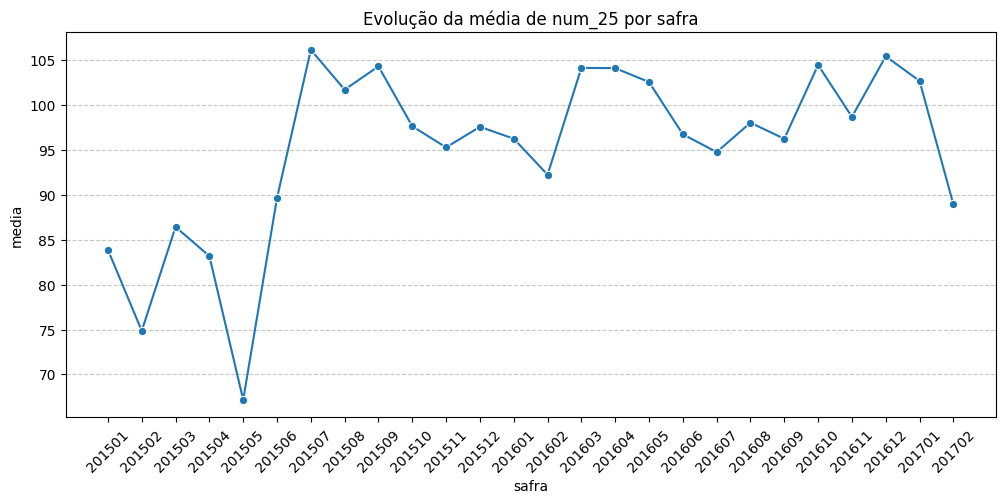

In [21]:
plot_tendencia_temporal(df_logs, col_valor="num_25", col_safra="safra")

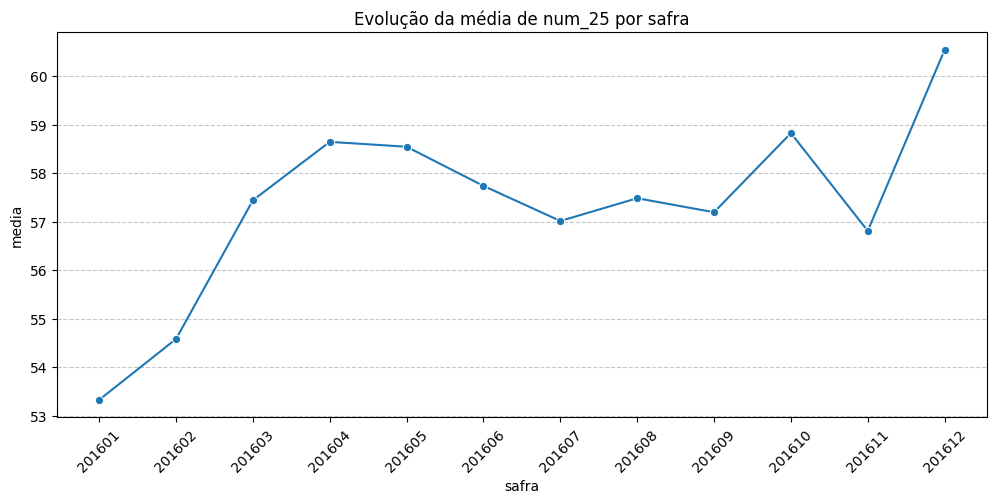

In [15]:
plot_tendencia_temporal(df_logs.filter((F.col("safra").between(201601, 201612)) & F.col("num_25").between(0, 247)), col_valor="num_25", col_safra="safra")

### num_50

In [24]:
df_logs.select("num_50").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+-----------------+
|summary|           num_50|
+-------+-----------------+
|  count|         26758971|
|   mean|24.03566975725636|
| stddev|39.12554591867814|
|    min|              0.0|
|     1%|              0.0|
|    10%|              0.0|
|    25%|              3.0|
|    50%|             11.0|
|    75%|             30.0|
|    95%|             89.0|
|  99.5%|            222.0|
|    max|           8875.0|
+-------+-----------------+



In [19]:
percentage = (df_logs.filter((F.col("num_50") > 30)).select("num_50").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_50 > 30")

24.81% dos registros têm num_50 > 30


In [30]:
percentage = (df_logs.filter((F.col("num_50").between(0, 30))).select("num_50").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_50 entre 0 e 30")

75.19% dos registros têm num_50 entre 0 e 30


In [18]:
percentage = (df_logs.filter((F.col("num_50").between(30, 100))).select("num_50").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_50 entre 30 e 100")

21.73% dos registros têm num_50 entre 30 e 100


In [31]:
percentage = (df_logs.filter((F.col("num_50").between(0, 100))).select("num_50").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_50 entre 0 e 100")

96.09% dos registros têm num_50 entre 0 e 100


In [23]:
percentage = (df_logs.filter(F.col("num_50") > 222).select("num_50").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_50 > 222")

0.50% dos registros têm num_50 > 222


In [28]:
identificar_outliers(df_logs, "num_50", negativo=False)

Variável num_50:
Limites: [0, 68.0]
Total de outliers (#): 2215100
Total de outliers (%): 8.28%


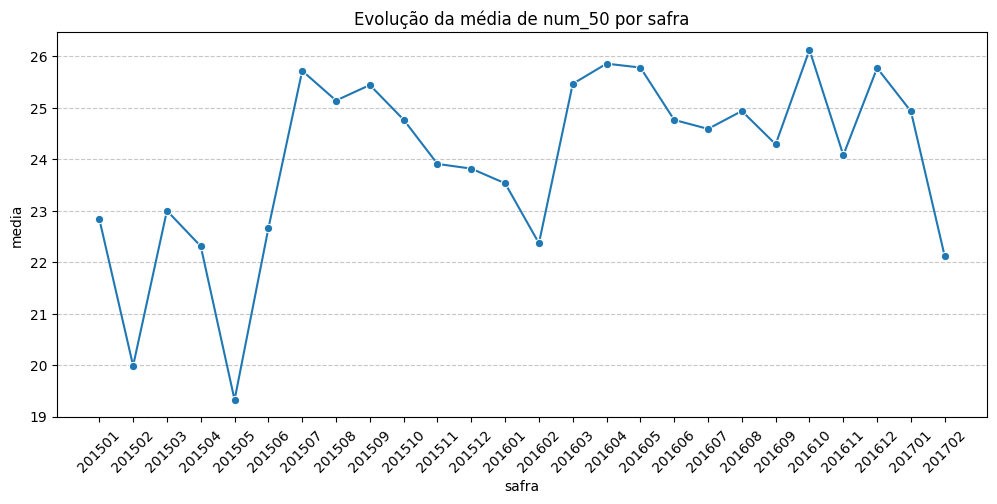

In [29]:
plot_tendencia_temporal(df_logs, col_valor="num_50", col_safra="safra")

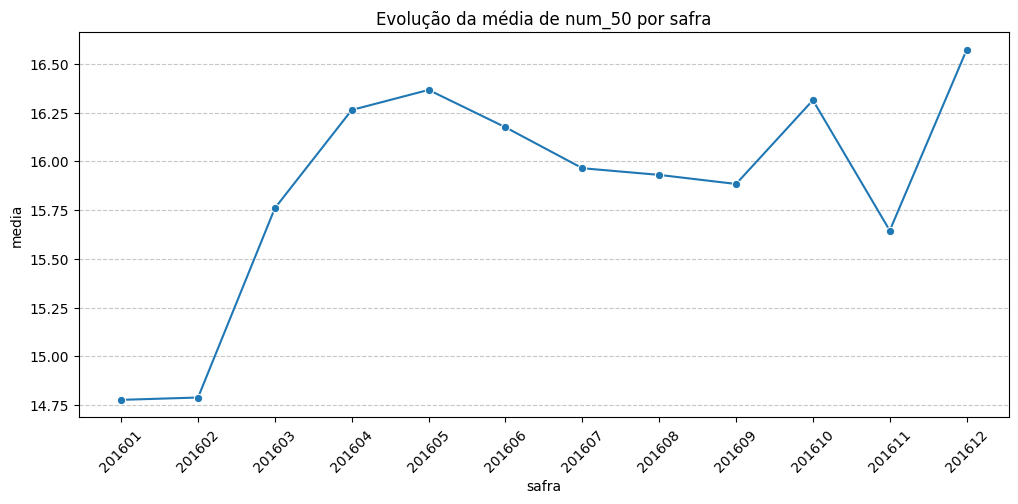

In [17]:
plot_tendencia_temporal(df_logs.filter((F.col("safra").between(201601, 201612)) & F.col("num_50").between(0, 68)), col_valor="num_50", col_safra="safra")

### num_75

In [26]:
df_logs.select("num_75").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+------------------+
|summary|            num_75|
+-------+------------------+
|  count|          26758971|
|   mean|14.903521327483034|
| stddev| 22.62672151325168|
|    min|               0.0|
|     1%|               0.0|
|    10%|               0.0|
|    25%|               2.0|
|    50%|               7.0|
|    75%|              20.0|
|    95%|              54.0|
|  99.5%|             127.0|
|    max|            3485.0|
+-------+------------------+



In [28]:
percentage = (df_logs.filter((F.col("num_75").between(0, 100))).select("num_75").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_75 entre 0 e 100")

98.99% dos registros têm num_75 entre 0 e 100


In [29]:
percentage = (df_logs.filter(F.col("num_75") > 127).select("num_75").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_75 > 127")

0.49% dos registros têm num_75 > 127


In [30]:
identificar_outliers(df_logs, "num_75", negativo=False)

Variável num_75:
Limites: [0, 42.0]
Total de outliers (#): 2208148
Total de outliers (%): 8.25%


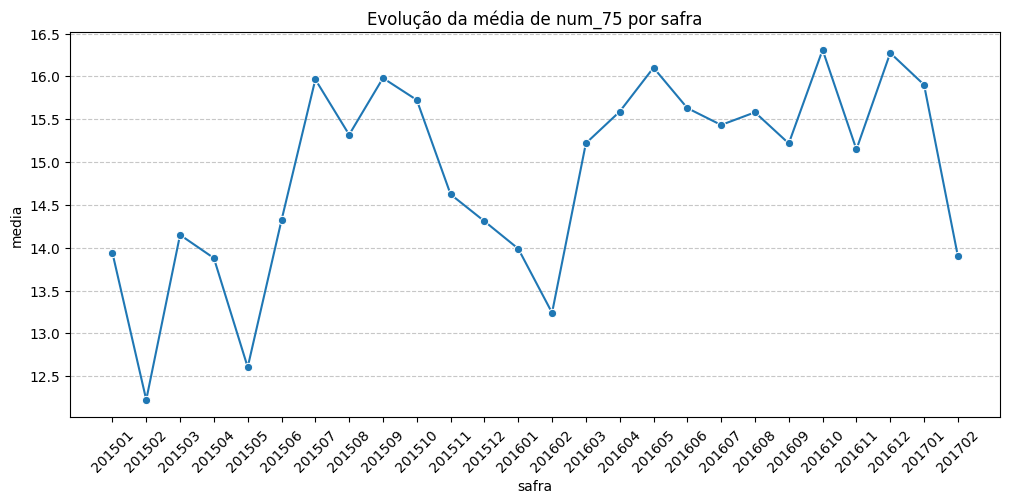

In [31]:
plot_tendencia_temporal(df_logs, col_valor="num_75", col_safra="safra")

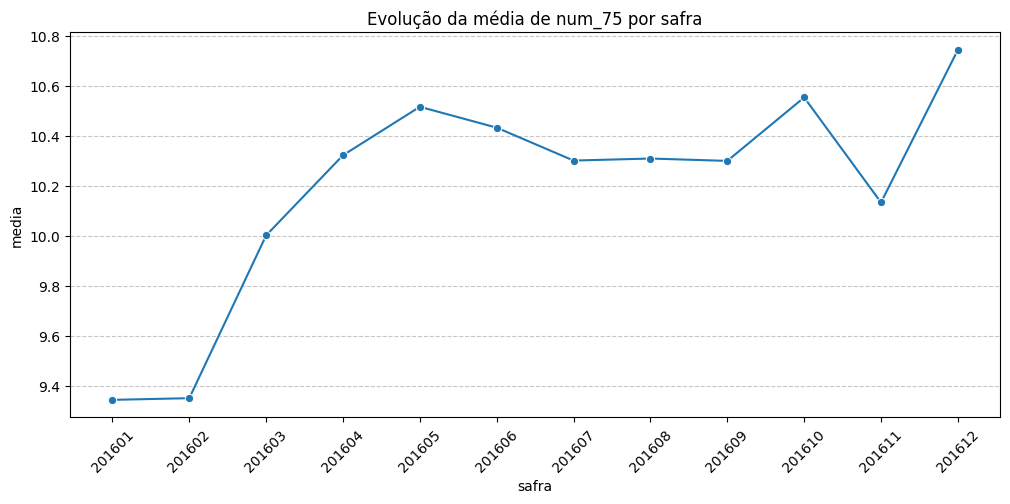

In [18]:
plot_tendencia_temporal(df_logs.filter((F.col("safra").between(201601, 201612)) & F.col("num_75").between(0, 42)), col_valor="num_75", col_safra="safra")

### num_985

In [32]:
df_logs.select("num_985").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+------------------+
|summary|           num_985|
+-------+------------------+
|  count|          26758971|
|   mean|16.538671797207748|
| stddev|37.409156681476375|
|    min|               0.0|
|     1%|               0.0|
|    10%|               0.0|
|    25%|               1.0|
|    50%|               7.0|
|    75%|              20.0|
|    95%|              60.0|
|  99.5%|             164.0|
|    max|           37698.0|
+-------+------------------+



In [33]:
percentage = (df_logs.filter((F.col("num_985").between(0, 100))).select("num_985").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_985 entre 0 e 100")

98.38% dos registros têm num_985 entre 0 e 100


In [34]:
percentage = (df_logs.filter(F.col("num_985") > 164).select("num_985").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_985 > 127")

0.49% dos registros têm num_985 > 127


In [32]:
identificar_outliers(df_logs, "num_985", negativo=False)

Variável num_985:
Limites: [0, 44.5]
Total de outliers (#): 2339963
Total de outliers (%): 8.74%


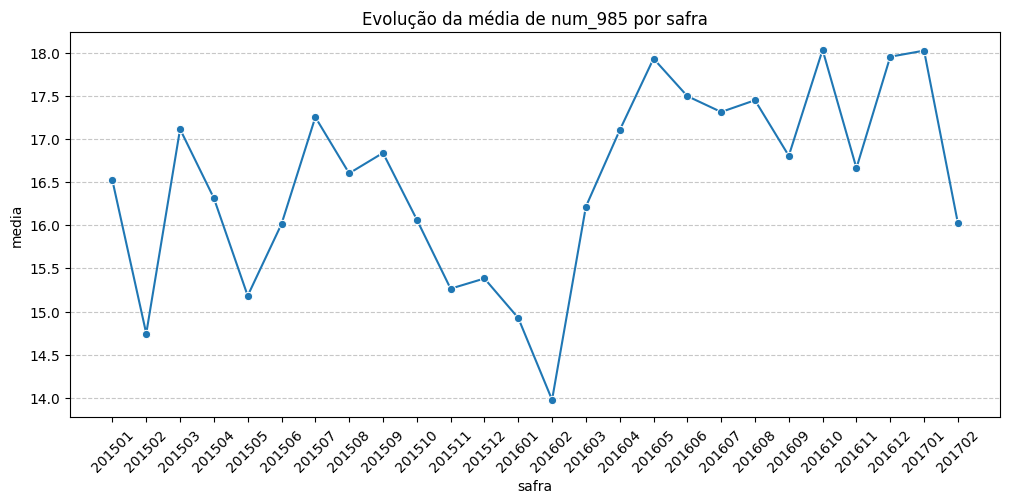

In [33]:
plot_tendencia_temporal(df_logs, col_valor="num_985", col_safra="safra")

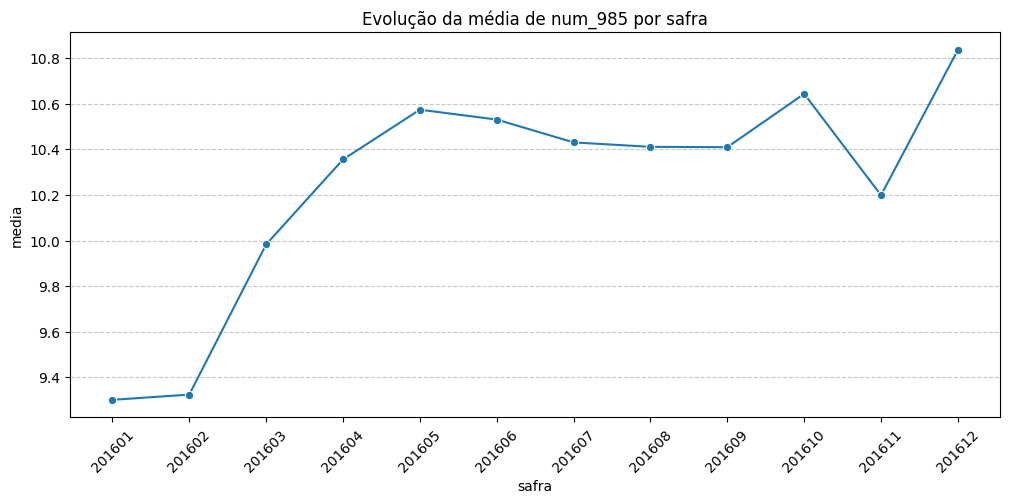

In [19]:
plot_tendencia_temporal(df_logs.filter((F.col("safra").between(201601, 201612)) & F.col("num_985").between(0, 43)), col_valor="num_985", col_safra="safra")

### num_100

In [35]:
df_logs.select("num_100").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+-----------------+
|summary|          num_100|
+-------+-----------------+
|  count|         26758971|
|   mean|450.1598216538297|
| stddev|725.3139035411615|
|    min|              0.0|
|     1%|              0.0|
|    10%|              2.0|
|    25%|             37.0|
|    50%|            211.0|
|    75%|            564.0|
|    95%|           1697.0|
|  99.5%|           4365.0|
|    max|         196741.0|
+-------+-----------------+



In [37]:
percentage = (df_logs.filter((F.col("num_100").between(0, 1700))).select("num_100").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_100 entre 0 e 1700")

95.02% dos registros têm num_100 entre 0 e 1700


In [39]:
percentage = (df_logs.filter(F.col("num_100") > 4365).select("num_100").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_100 > 4365")

0.50% dos registros têm num_100 > 4365


In [34]:
identificar_outliers(df_logs, "num_100", negativo=False)

Variável num_100:
Limites: [0, 1277.5]
Total de outliers (#): 2190020
Total de outliers (%): 8.18%


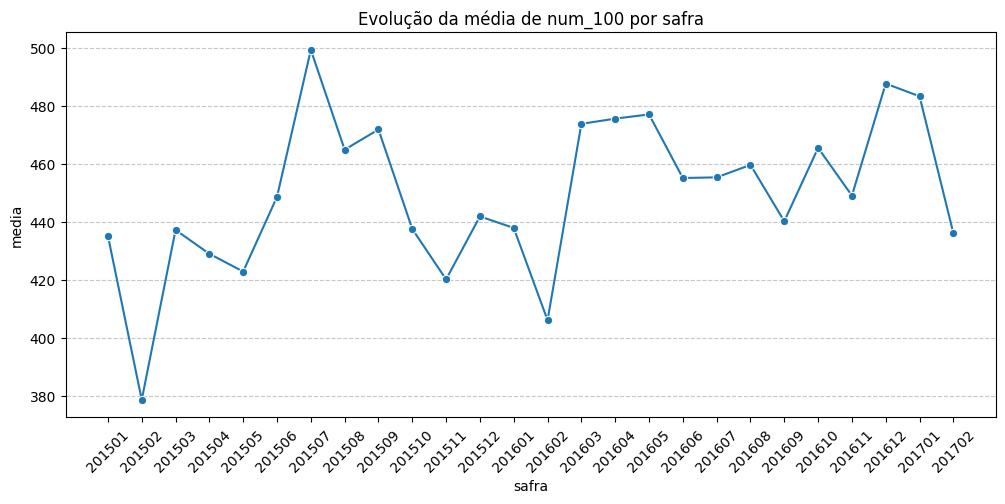

In [35]:
plot_tendencia_temporal(df_logs, col_valor="num_100", col_safra="safra")

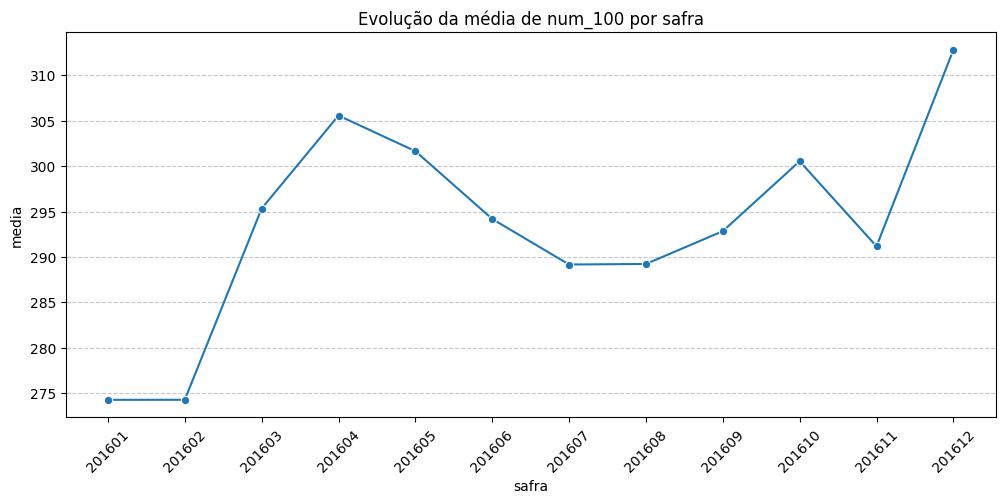

In [20]:
plot_tendencia_temporal(df_logs.filter((F.col("safra").between(201601, 201612)) & F.col("num_100").between(0, 1278)), col_valor="num_100", col_safra="safra")

### num_unq

In [40]:
df_logs.select("num_unq").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+------------------+
|summary|           num_unq|
+-------+------------------+
|  count|          26758971|
|   mean|440.91930526775485|
| stddev| 590.6059571748677|
|    min|               1.0|
|     1%|               1.0|
|    10%|               7.0|
|    25%|              50.0|
|    50%|             239.0|
|    75%|             600.0|
|    95%|            1559.0|
|  99.5%|            3398.0|
|    max|           32706.0|
+-------+------------------+



In [42]:
percentage = (df_logs.filter((F.col("num_unq").between(0, 3400))).select("num_unq").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_unq entre 0 e 3400")

99.50% dos registros têm num_unq entre 0 e 3400


In [43]:
percentage = (df_logs.filter(F.col("num_unq") > 3398).select("num_unq").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_unq > 3398")

0.50% dos registros têm num_unq > 3398


In [36]:
identificar_outliers(df_logs, "num_unq", negativo=False)

Variável num_unq:
Limites: [0, 1345.5]
Total de outliers (#): 1842121
Total de outliers (%): 6.88%


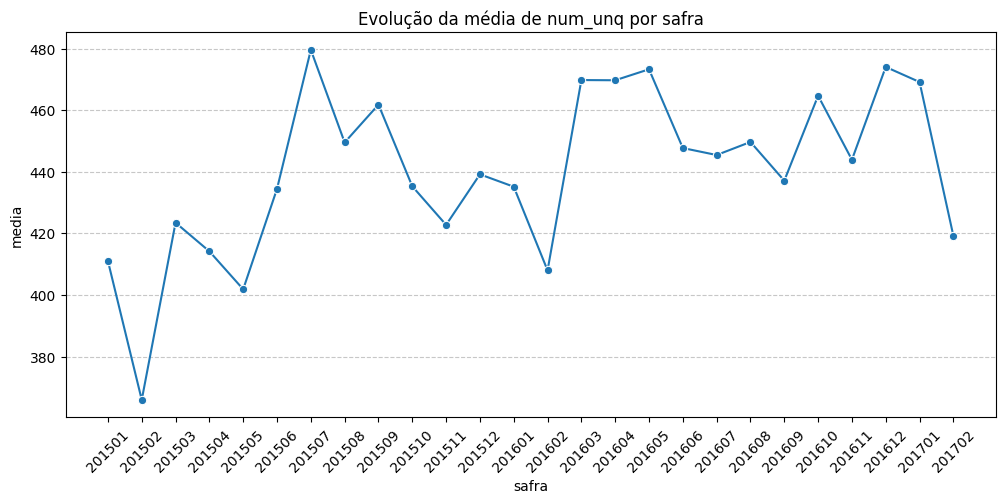

In [37]:
plot_tendencia_temporal(df_logs, col_valor="num_unq", col_safra="safra")

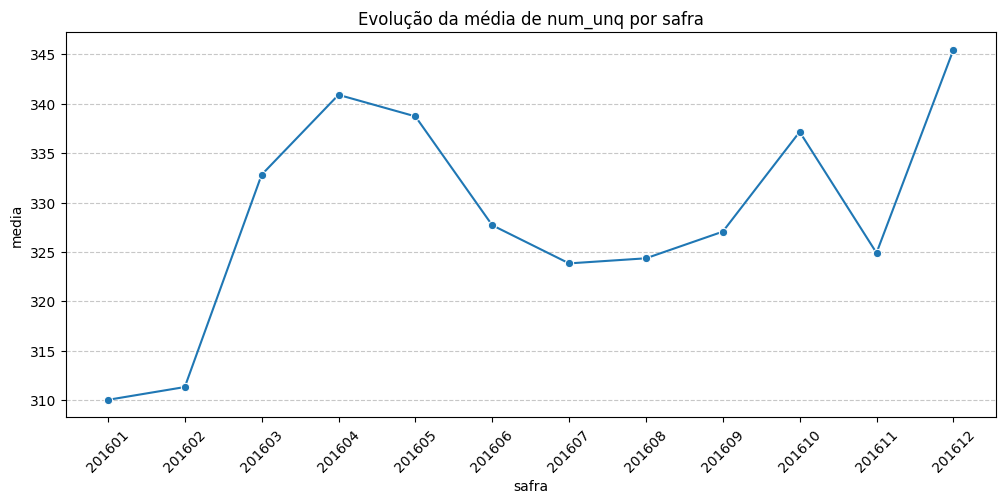

In [21]:
plot_tendencia_temporal(df_logs.filter((F.col("safra").between(201601, 201612)) & F.col("num_unq").between(0, 1346)), col_valor="num_unq", col_safra="safra")

### total_secs

In [44]:
df_logs.select("total_secs").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+--------------------+
|summary|          total_secs|
+-------+--------------------+
|  count|            26758971|
|   mean|-2.11717488634759...|
| stddev|6.839043702349422E14|
|    min|-2.39807672957245...|
|     1%|              28.797|
|    10%|             1041.48|
|    25%|           11021.553|
|    50%|  58359.429000000004|
|    75%|          152111.487|
|    95%|          441495.728|
|  99.5%|  1072298.1889999998|
|    max|9.223372037135594E15|
+-------+--------------------+



In [46]:
percentage = (df_logs.filter((F.col("total_secs") < 0)).select("total_secs").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm total_secs menor do que 0")

0.16% dos registros têm total_secs menor do que 0


In [45]:
df_logs.filter(F.col("total_secs") > 0).select("total_secs").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+--------------------+
|summary|          total_secs|
+-------+--------------------+
|  count|            26716625|
|   mean|1.596254162738099...|
| stddev|1.210745784107657...|
|    min|               0.001|
|     1%|              35.082|
|    10%|            1069.775|
|    25%|  11162.853000000001|
|    50%|   58566.95500000001|
|    75%|          152332.517|
|    95%|          441852.025|
|  99.5%|  1072298.1889999998|
|    max|9.223372037135594E15|
+-------+--------------------+



In [38]:
identificar_outliers(df_logs, "total_secs", negativo=False)

Variável total_secs:
Limites: [0, 344114.68700000003]
Total de outliers (#): 2146972
Total de outliers (%): 8.02%


In [42]:
(344114/(60*60*24)) # conversão para dias

3.982800925925926

OBS: Depois de verificar correlacao entre as variaveis, seria interessante levantar o seguinte ponto para feature_store: ver qual o valor de num_percent maior e atribuir um peso em cima dessas categorias.

### total_days --> from total_secs

In [23]:
df_logs = df_logs.withColumn("total_days", F.col("total_secs") / (60*60*24))

In [50]:
df_logs.select("total_days").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show(truncate=False)

+-------+---------------------+
|summary|total_days           |
+-------+---------------------+
|count  |26758971             |
|mean   |-2.4504338962349823E8|
|stddev |7.915559840682272E9  |
|min    |-2.775551770338489E12|
|1%     |3.3329861111111114E-4|
|10%    |0.012054166666666666 |
|25%    |0.12756427083333333  |
|50%    |0.6754563541666667   |
|75%    |1.7605496180555555   |
|95%    |5.10990425925926     |
|99.5%  |12.41085866898148    |
|max    |1.0675199117055086E11|
+-------+---------------------+



Possivel separar entre quem ouviu por faixas de dias. Menos de um dia, entre 1 e 3 dias...faz sentido? Ou seria melhor manter somente o valor da variavel numerica?

In [48]:
identificar_outliers(df_logs, "total_days", negativo=False)

Variável total_days:
Limites: [0, 3.982808877314815]
Total de outliers (#): 2146972
Total de outliers (%): 8.02%


In [51]:
percentage = (df_logs.filter((F.col("total_days").between(0, 15))).select("total_days").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm total_days entre 0 e 15")

99.64% dos registros têm total_days entre 0 e 15


In [24]:
percentage = (df_logs.filter((F.col("total_days").between(0, 4))).select("total_days").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm total_days entre 0 e 4")

92.04% dos registros têm total_days entre 0 e 4


In [25]:
percentage = (df_logs.filter((F.col("total_days").between(0, 1))).select("total_days").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm total_days entre 0 e 1")

59.44% dos registros têm total_days entre 0 e 1


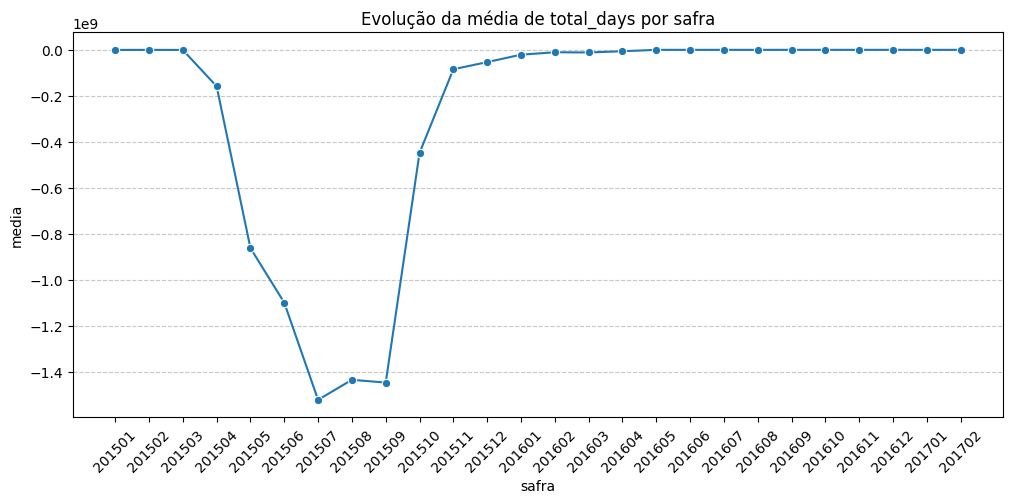

In [52]:
plot_tendencia_temporal(df_logs, col_valor="total_days", col_safra="safra")

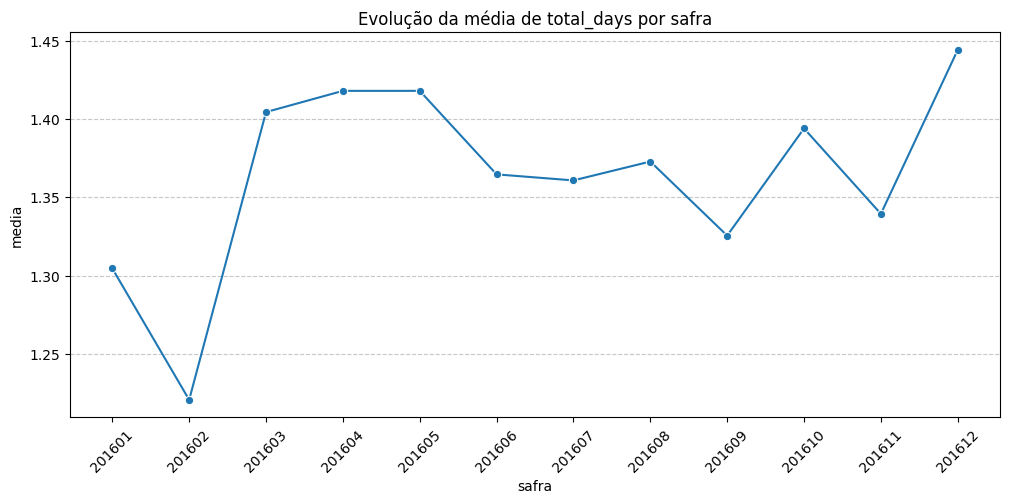

In [31]:
plot_tendencia_temporal(df_logs.filter((F.col("safra").between(201601, 201612)) & F.col("total_days").between(0, 15)), col_valor="total_days", col_safra="safra")

### completed_songs --> from num_numbers

In [39]:
df_logs = df_logs.withColumn("total_plays", F.col("num_25") + F.col("num_50") + F.col("num_75") + F.col("num_985") + F.col("num_100"))
    
# Cálculo da taxa de completude com tratamento de divisão por zero
df_logs = df_logs.withColumn("completed_songs_rate",
    F.when(F.col("total_plays") > 0, F.col("num_100") / F.col("total_plays")).otherwise(0.0))

df_logs = df_logs.drop("total_plays")

In [34]:
df_logs.select("completed_songs_rate").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show(truncate=False)

+-------+--------------------+
|summary|completed_songs_rate|
+-------+--------------------+
|count  |26758971            |
|mean   |0.6429295856112768  |
|stddev |0.2662612402357104  |
|min    |0.0                 |
|1%     |0.0                 |
|10%    |0.225               |
|25%    |0.5                 |
|50%    |0.7058823529411765  |
|75%    |0.8463576158940397  |
|95%    |0.9670958512160229  |
|99.5%  |1.0                 |
|max    |1.0                 |
+-------+--------------------+



In [45]:
identificar_outliers(df_logs, "completed_songs_rate", negativo=False)

Variável completed_songs_rate:
Limites: [0, 1.3333333333333335]
Total de outliers (#): 0
Total de outliers (%): 0.00%


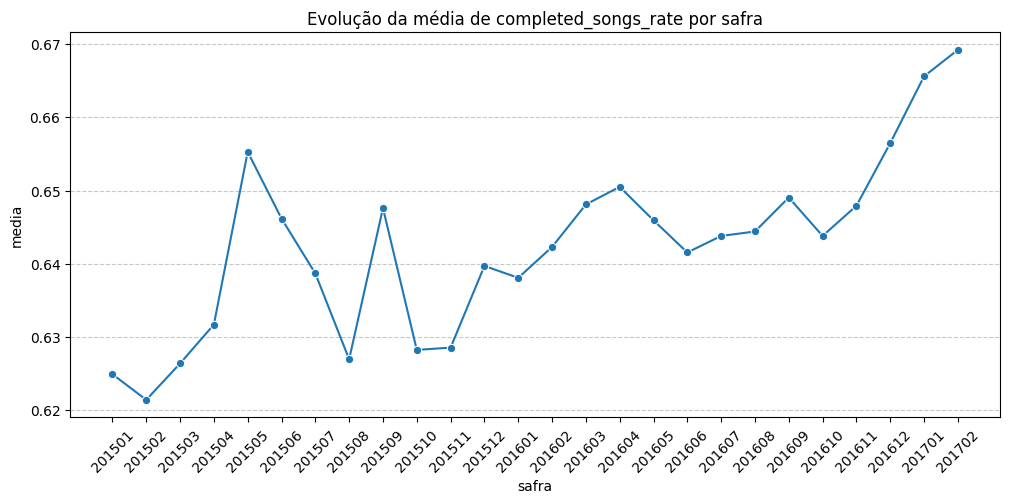

In [38]:
plot_tendencia_temporal(df_logs, col_valor="completed_songs_rate", col_safra="safra")

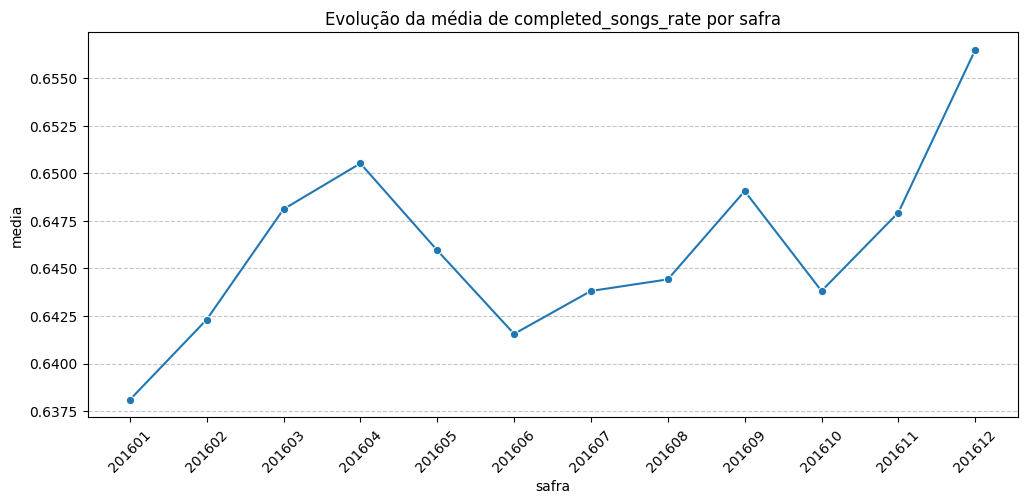

In [37]:
plot_tendencia_temporal(df_logs.filter((F.col("safra").between(201601, 201612))), col_valor="completed_songs_rate", col_safra="safra")

### direct_cost: 50 + 0.0051 * num\_unq + 0.0001 * total\_secs

In [47]:
df_logs = df_logs.withColumn("direct_cost", (50 + (0.0051 * F.col("num_unq")) + (0.0001 * F.col("total_secs"))))
df_logs = df_logs.withColumn("direct_cost", F.when(F.col("direct_cost") < 50.0, 50.0).otherwise(F.col("direct_cost")))

In [48]:
df_logs.select("direct_cost").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show(truncate=False)

+-------+--------------------+
|summary|direct_cost         |
+-------+--------------------+
|count  |26758971            |
|mean   |1593780.3351396902  |
|stddev |1.2097874054439375E9|
|min    |50.0                |
|1%     |50.0094893          |
|10%    |50.1433909          |
|25%    |51.3857325          |
|50%    |57.144163500000005  |
|75%    |68.3760931          |
|95%    |101.787799          |
|99.5%  |172.99474699999996  |
|max    |9.223372037680117E11|
+-------+--------------------+



In [49]:
identificar_outliers(df_logs, "direct_cost")

Variável direct_cost:
Limites: [27.221311700000008, 91.50429409999998]
Total de outliers (#): 2030113
Total de outliers (%): 7.59%


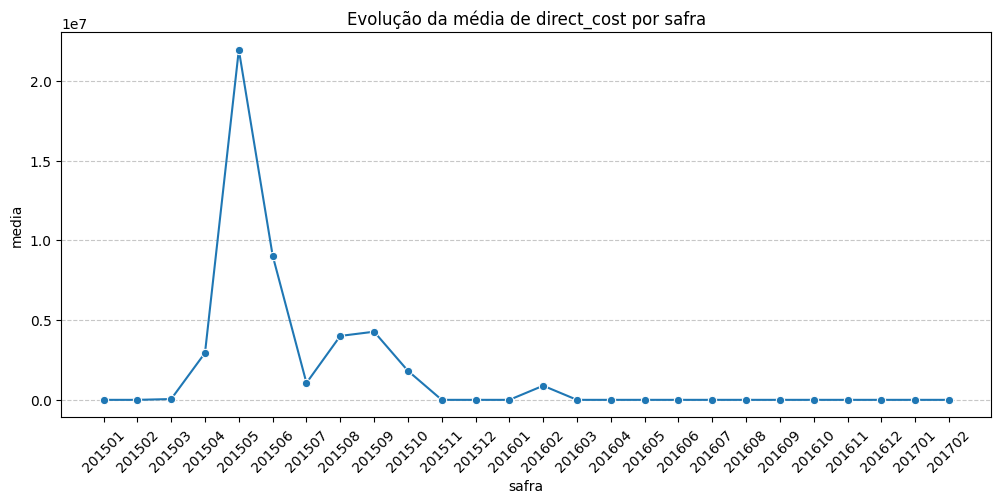

In [51]:
plot_tendencia_temporal(df_logs, col_valor="direct_cost", col_safra="safra")

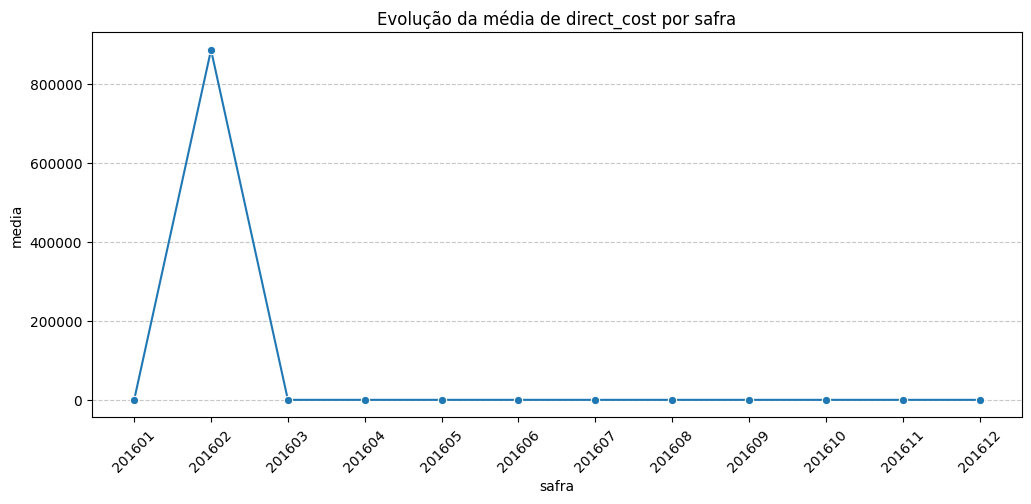

In [52]:
plot_tendencia_temporal(df_logs.filter((F.col("safra").between(201601, 201612))), col_valor="direct_cost", col_safra="safra")

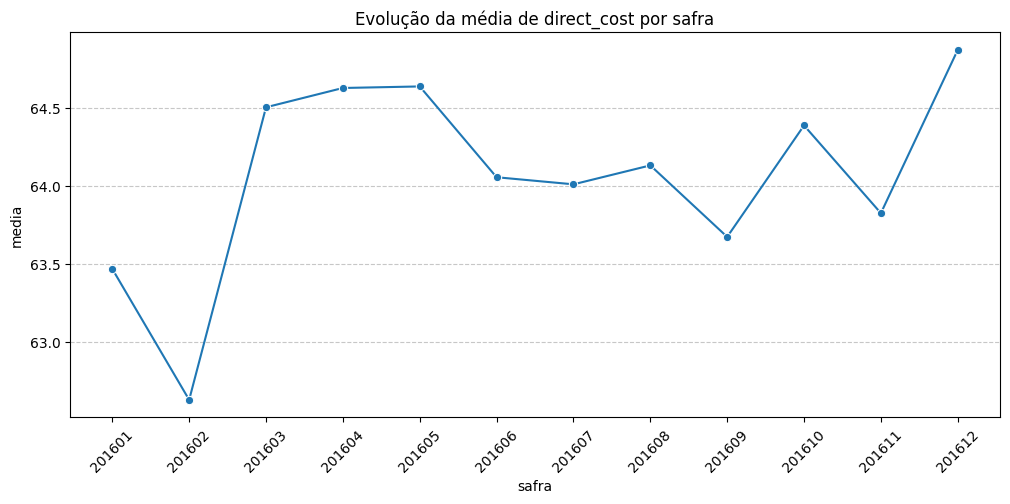

In [56]:
plot_tendencia_temporal(df_logs.filter((F.col("safra").between(201601, 201612)) & (F.col("direct_cost") < 200)), col_valor="direct_cost", col_safra="safra")

### Correlação - inserir pos etapa de feature engineering

#### Sem tratamento de outliers

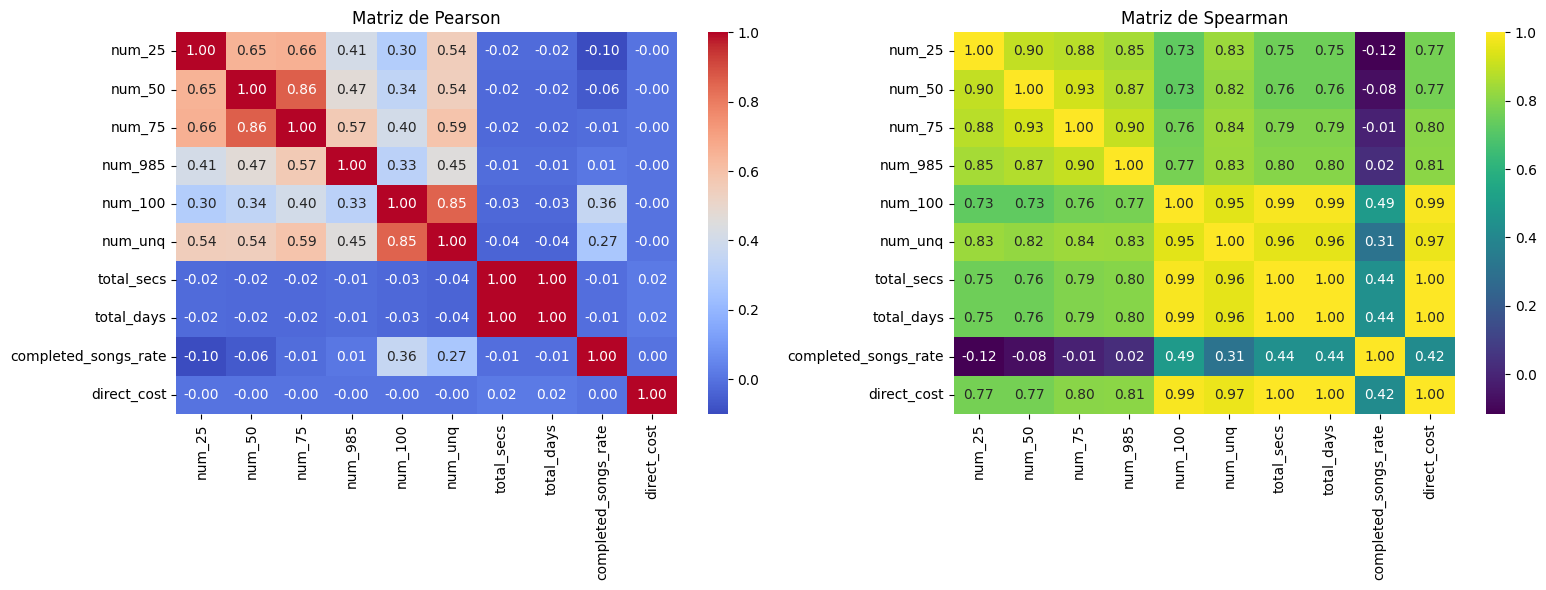

(                        num_25    num_50    num_75   num_985   num_100  \
 num_25                1.000000  0.650072  0.660435  0.407206  0.298916   
 num_50                0.650072  1.000000  0.863763  0.468252  0.342047   
 num_75                0.660435  0.863763  1.000000  0.565739  0.402806   
 num_985               0.407206  0.468252  0.565739  1.000000  0.325132   
 num_100               0.298916  0.342047  0.402806  0.325132  1.000000   
 num_unq               0.544709  0.542394  0.588550  0.454277  0.854030   
 total_secs           -0.022581 -0.023214 -0.024492 -0.014503 -0.027573   
 total_days           -0.022581 -0.023214 -0.024492 -0.014503 -0.027573   
 completed_songs_rate -0.100234 -0.064219 -0.014394  0.011163  0.357497   
 direct_cost          -0.000330 -0.000192 -0.000211 -0.000165 -0.000469   
 
                        num_unq  total_secs  total_days  completed_songs_rate  \
 num_25                0.544709   -0.022581   -0.022581             -0.100234   
 num_50    

In [58]:
analise_correlacao_quantitativa(df_logs, ["num_25", "num_50", "num_75", "num_985", "num_100", "num_unq", "total_secs", "total_days", "completed_songs_rate", "direct_cost"])

#### Com tratamento de outliers

In [15]:
df_logs_fix = aplicar_winsorizacao(df_logs, ["num_25", "num_50", "num_75", "num_985", "num_100", "num_unq", "total_secs"])

Coluna num_25: Limite Inferior=0.0, Limite Superior=746.0
Coluna num_50: Limite Inferior=0.0, Limite Superior=174.0
Coluna num_75: Limite Inferior=0.0, Limite Superior=101.0
Coluna num_985: Limite Inferior=0.0, Limite Superior=122.0
Coluna num_100: Limite Inferior=0.0, Limite Superior=3487.0
Coluna num_unq: Limite Inferior=1.0, Limite Superior=2819.0
Coluna total_secs: Limite Inferior=28.11, Limite Superior=881683.002


In [16]:
df_logs_fix = (df_logs_fix
    .withColumn("total_days", F.col("total_secs") / (60*60*24))
    .withColumn("completed_songs_rate",
        F.when((F.col("num_25") + F.col("num_50") + F.col("num_75") + F.col("num_985") + F.col("num_100") > 0),
               (F.col("num_100") / (F.col("num_25") + F.col("num_50") + F.col("num_75") + F.col("num_985") + F.col("num_100"))))
               .otherwise(0.0))
    .withColumn("direct_cost", (50 + (0.0051 * F.col("num_unq")) + (0.0001 * F.col("total_secs"))))
    .withColumn("direct_cost", F.when(F.col("direct_cost") < 50.0, 50.0).otherwise(F.col("direct_cost")))
)

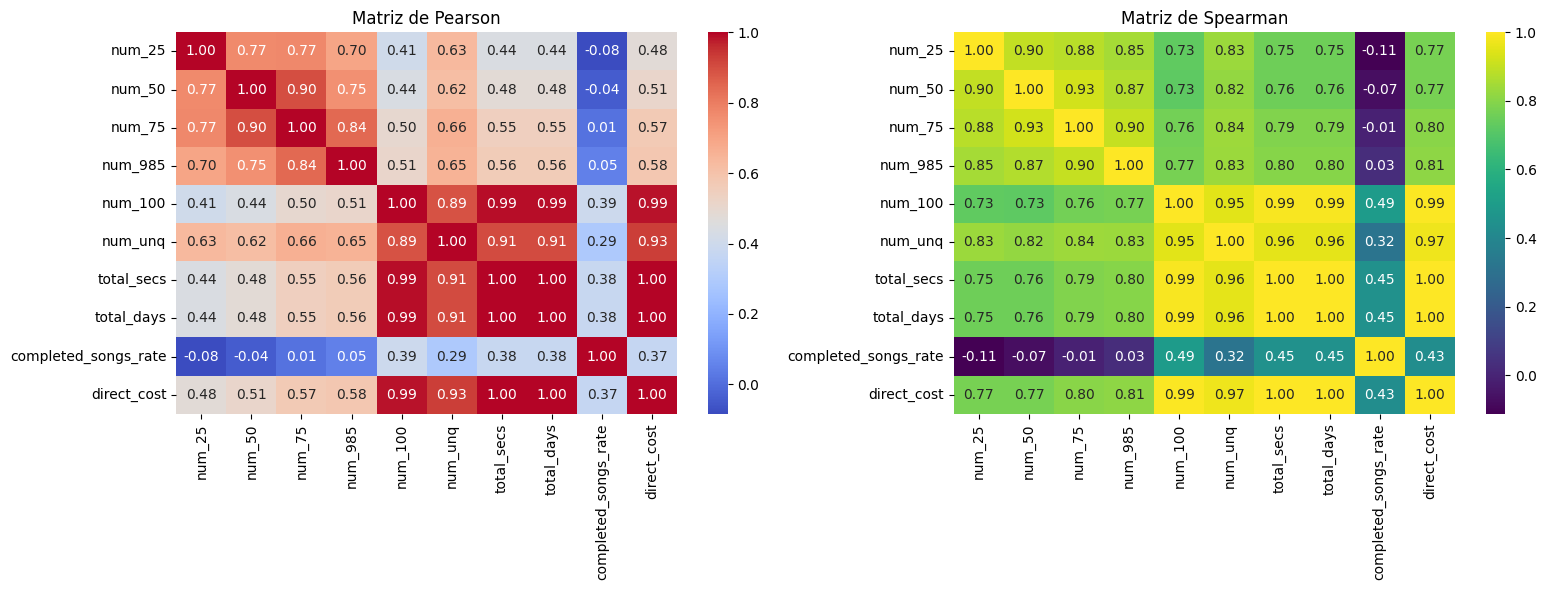

(                        num_25    num_50    num_75   num_985   num_100  \
 num_25                1.000000  0.770349  0.774383  0.698305  0.405307   
 num_50                0.770349  1.000000  0.902022  0.752818  0.437046   
 num_75                0.774383  0.902022  1.000000  0.844033  0.499662   
 num_985               0.698305  0.752818  0.844033  1.000000  0.510703   
 num_100               0.405307  0.437046  0.499662  0.510703  1.000000   
 num_unq               0.634334  0.616295  0.661861  0.653989  0.893450   
 total_secs            0.444207  0.483376  0.546357  0.560823  0.989622   
 total_days            0.444207  0.483376  0.546357  0.560823  0.989622   
 completed_songs_rate -0.083729 -0.043263  0.013206  0.048805  0.393819   
 direct_cost           0.477942  0.509059  0.570208  0.581520  0.987300   
 
                        num_unq  total_secs  total_days  completed_songs_rate  \
 num_25                0.634334    0.444207    0.444207             -0.083729   
 num_50    

In [17]:
analise_correlacao_quantitativa(df_logs_fix, ["num_25", "num_50", "num_75", "num_985", "num_100", "num_unq", "total_secs", "total_days", "completed_songs_rate", "direct_cost"])

##### 📝 Conclusoes para Feature Selection

* **Manter**: `total_secs`, `num_unq`, `completed_songs_rate`.
* **Descartar**: `total_days` (redundante), `num_100` (colinearidade extrema com tempo), `num_50` e `num_75` (redundantes com `num_25`).

> Observacao: Manter `num_unq` com `total_secs` apresenta multicolinearidade, dado que sao proximas entre si. No entanto, cada uma tem um peso diferente no custo final: `num_unq` pesa sobre a diversidade e `total_secs` sobre o volume de infraestrutura. O fato de a correlação de Spearman (0.96) ser maior que a de Pearson (0.91) sugere que a relação entre elas é extremamente consistente em termos de ranking (quem ouve mais tempo quase sempre ouve mais músicas únicas), mesmo que essa relação não seja perfeitamente linear em todos os níveis de consumo.

## Analise Especifica de Tabela: transactions

### dictionary

Definition: transactions of users up until 3/31/2017.

* msno: user id
* payment_method_id: payment method
* payment_plan_days: length of membership plan in days
* plan_list_price: in New Taiwan Dollar (NTD)
* actual_amount_paid: in New Taiwan Dollar 
(NTD)
* is_auto_renew: automatic renovation on/off
* transaction_date: format %Y%m%d
* membership_expire_date: format %Y%m%d
* is_cancel: whether or not the user canceled the 
membership in this transaction.



### general info

In [15]:
total_transactions = df_transactions.count()
total_transactions

20712225

In [54]:
df_transactions.printSchema()

root
 |-- msno: string (nullable = true)
 |-- payment_method_id: string (nullable = true)
 |-- payment_plan_days: string (nullable = true)
 |-- plan_list_price: string (nullable = true)
 |-- actual_amount_paid: string (nullable = true)
 |-- is_auto_renew: string (nullable = true)
 |-- transaction_date: string (nullable = true)
 |-- membership_expire_date: string (nullable = true)
 |-- is_cancel: string (nullable = true)
 |-- safra: integer (nullable = true)



In [55]:
df_transactions.show(10, truncate=False)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|38               |410              |1788           |1788              |0            |20151121        |20170104              |0        |201511|
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|41               |30               |149            |149               |1            |20150526        |20150626              |0        |201505|
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|41       

#### Duplicatas e aparicoes

In [56]:
print("Número de duplicatas encontradas: " + str(verificar_duplicatas(df_transactions)))

Número de duplicatas encontradas: 0


In [25]:
trans_contagem = df_transactions.groupBy('msno').agg(F.count('*').alias('contagem'))
trans_contagem.select("contagem").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "99.5%", "max").show()

+-------+-----------------+
|summary|         contagem|
+-------+-----------------+
|  count|          2363626|
|   mean|8.762902845035551|
| stddev|8.580922690781978|
|    min|                1|
|    25%|                1|
|    50%|                5|
|    75%|               15|
|  99.5%|               26|
|    max|               26|
+-------+-----------------+



In [57]:
contagem_trans = trans_contagem.count()
calcular_distribuicao(trans_contagem, "contagem", contagem_trans, col_id="contagem")

+--------+------+---------+
|contagem| total|pct_total|
+--------+------+---------+
|       1|665663|    28.16|
|       2|313299|    13.26|
|      26|182281|     7.71|
|       3|112866|     4.78|
|       4| 80113|     3.39|
|      19| 79431|     3.36|
|      14| 65923|     2.79|
|      22| 64390|     2.72|
|       8| 63216|     2.67|
|       5| 61995|     2.62|
+--------+------+---------+
only showing top 10 rows



In [27]:
contagem_safra_trans = df_transactions.select("safra").distinct().count()
print(f"O número de safras na base é: {contagem_safra_trans}")

O número de safras na base é: 26


### plan_list_price + actual_amount_paid

In [39]:
df_transactions.select("plan_list_price").distinct().orderBy("plan_list_price").show(100)

+---------------+
|plan_list_price|
+---------------+
|              0|
|              1|
|             10|
|            100|
|           1000|
|            105|
|           1150|
|            119|
|            120|
|           1200|
|            124|
|            126|
|            129|
|            131|
|            134|
|            143|
|            149|
|             15|
|            150|
|           1520|
|           1599|
|           1788|
|            180|
|           1825|
|           2000|
|            210|
|            265|
|            298|
|             30|
|            300|
|             35|
|            350|
|            400|
|             44|
|            447|
|            450|
|            477|
|            480|
|             50|
|            500|
|            536|
|            596|
|            600|
|            699|
|             70|
|            760|
|            799|
|            800|
|            894|
|            930|
|             99|
+---------------+



In [16]:
df_transactions.groupBy("plan_list_price", "actual_amount_paid").count().orderBy(F.desc("count")).show(40)

+---------------+------------------+--------+
|plan_list_price|actual_amount_paid|   count|
+---------------+------------------+--------+
|            149|               149|11233604|
|             99|                99| 4774736|
|            129|               129| 1096720|
|              0|               149|  764403|
|            180|               180|  656705|
|              0|                 0|  562167|
|            149|                 0|  484549|
|            150|               150|  360929|
|            149|               119|  270324|
|            894|               894|  107881|
|           1788|              1788|   78940|
|            100|               100|   75569|
|            536|               536|   42850|
|            119|               119|   29195|
|              0|               129|   25410|
|              0|               119|   23335|
|            480|               480|   22736|
|              0|               150|   12462|
|           1599|              159

In [52]:
calcular_distribuicao(df_transactions, ["plan_list_price", "actual_amount_paid"], n_show=10)

+---------------+------------------+--------+---------+
|plan_list_price|actual_amount_paid|total   |pct_total|
+---------------+------------------+--------+---------+
|149            |149               |11233604|54.24    |
|99             |99                |4774736 |23.05    |
|129            |129               |1096720 |5.3      |
|0              |149               |764403  |3.69     |
|180            |180               |656705  |3.17     |
|0              |0                 |562167  |2.71     |
|149            |0                 |484549  |2.34     |
|150            |150               |360929  |1.74     |
|149            |119               |270324  |1.31     |
|894            |894               |107881  |0.52     |
+---------------+------------------+--------+---------+
only showing top 10 rows



DataFrame[plan_list_price: string, actual_amount_paid: string, total: bigint, pct_total: double]

Nem tudo o que deveriam pagar foi efetivamente pago em alguns casos, bem como aparentemente houveram pagamentos que nao deveriam ter sido executados.

In [55]:
df_transactions_anl = df_transactions.withColumn("payment_diff", F.col("actual_amount_paid") - F.col("plan_list_price"))
df_transactions_anl = df_transactions_anl.withColumn("flag_pag_diff", F.when(F.col("payment_diff") != 0, 1).otherwise(0))

In [56]:
percentage = df_transactions_anl.filter(F.col("flag_pag_diff") == 1).count() / df_transactions_anl.count() * 100
print(f"{percentage:.2f}% dos registros têm divergência no pagamento.")

7.71% dos registros têm divergência no pagamento.


In [63]:
flag_pag_diff_per_safra = calcular_distribuicao(df_transactions_anl, ["flag_pag_diff"], n_show=60, agrupar_por_safra=True)

+------+-------------+-------+---------+---------+
|safra |flag_pag_diff|total  |pct_safra|pct_total|
+------+-------------+-------+---------+---------+
|201501|0            |490695 |89.41    |2.37     |
|201501|1            |58097  |10.59    |0.28     |
|201502|0            |492343 |90.29    |2.38     |
|201502|1            |52960  |9.71     |0.26     |
|201503|0            |501826 |80.1     |2.42     |
|201503|1            |124662 |19.9     |0.6      |
|201504|0            |341355 |60.46    |1.65     |
|201504|1            |223227 |39.54    |1.08     |
|201505|0            |323465 |56.59    |1.56     |
|201505|1            |248087 |43.41    |1.2      |
|201506|0            |663052 |85.47    |3.2      |
|201506|1            |112685 |14.53    |0.54     |
|201507|0            |550109 |82.69    |2.66     |
|201507|1            |115171 |17.31    |0.56     |
|201508|0            |585194 |82.89    |2.83     |
|201508|1            |120781 |17.11    |0.58     |
|201509|0            |593645 |8

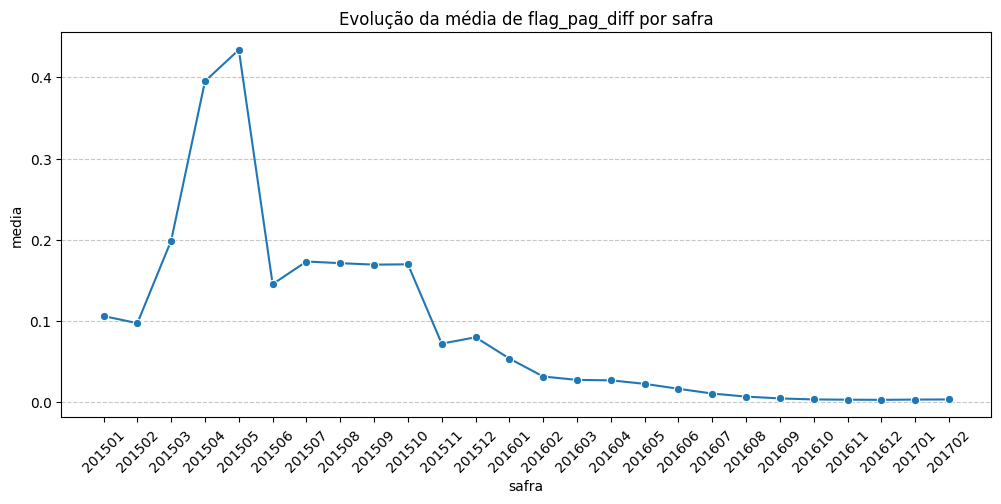

In [62]:
plot_tendencia_temporal(df_transactions_anl, col_valor="flag_pag_diff", col_safra="safra")

In [64]:
flag_pag_diff_per_safra.filter(F.col("flag_pag_diff").isin([0])).groupBy("flag_pag_diff").agg(F.mean("pct_safra").alias("media_pgt_correto")).orderBy("flag_pag_diff").show(1)

+-------------+-----------------+
|flag_pag_diff|media_pgt_correto|
+-------------+-----------------+
|            0|90.67346153846152|
+-------------+-----------------+



90% dos pagamentos feitos estao concordantes com o valor cobrado. Os demais sao casos de erro?

### payment_method_id

Verificar se o metodo de pagamento dos clientes mudou ao longo do periodo

In [22]:
verificar_mudanca_estado(df_transactions, col_alvo="payment_method_id", visualizar=True)

Contagem de mudanças por safra:
+------+-----+-----+
|safra |mudou|count|
+------+-----+-----+
|201502|true |3637 |
|201503|true |4998 |
|201504|true |7434 |
|201505|true |8885 |
|201506|true |24154|
|201507|true |13619|
|201508|true |13737|
|201509|true |14670|
|201510|true |13727|
|201511|true |13463|
|201512|true |19871|
|201601|true |14609|
|201602|true |22316|
|201603|true |13574|
|201604|true |12695|
|201605|true |13231|
|201606|true |14387|
|201607|true |27179|
|201608|true |25557|
|201609|true |24162|
|201610|true |28990|
|201611|true |36827|
|201612|true |20930|
|201701|true |17245|
|201702|true |14828|
+------+-----+-----+

Mudanças por usuário:
+--------------------------------------------+--------------+
|msno                                        |total_mudancas|
+--------------------------------------------+--------------+
|++hTNyKbQJonbwH4zStU+NGBhqxsUwQ++qQwLaZJliA=|1             |
|++wAgGfr8qioOG5N+4vbhDT5Mnv6uqLll7T5AnNxPTc=|2             |
|+/H9aTMCulY64Kzq7YxYXXoPn

A mudanca no metodo de pagamento é fator relevante para o cancelamento da assinatura do cliente?

In [23]:
# Janela por usuário para ver histórico
window_msno = Window.partitionBy("msno").orderBy("transaction_date")

df_trans_features = (df_transactions
    # Criar coluna do método de pagamento anterior para mapear mudança e verificar se afeta na taxa de cancelamento
    .withColumn("payment_method_id_anterior", F.lag("payment_method_id").over(window_msno))
    .withColumn("mudou_metodo_pagto", 
        F.when(F.col("payment_method_id_anterior").isNull(), 0)
        .when(F.col("payment_method_id") != F.col("payment_method_id_anterior"), 1)
        .otherwise(0))
)

# Resumo de relevância: Média de cancelamento para quem muda método
df_trans_features_agg = df_trans_features.groupBy("safra", "mudou_metodo_pagto").agg(
    F.round(F.avg("is_cancel") * 100, 2).alias("taxa_cancelamento_media"),
    F.count("msno").alias("volumetria")).orderBy("safra", "mudou_metodo_pagto")

df_trans_features_agg.groupBy("mudou_metodo_pagto").agg(
    F.round(F.avg("taxa_cancelamento_media"), 2).alias("taxa_cancelamento_media_geral"),
    F.sum("volumetria").alias("volumetria_total")).orderBy("mudou_metodo_pagto").show(10, truncate=False)

+------------------+-----------------------------+----------------+
|mudou_metodo_pagto|taxa_cancelamento_media_geral|volumetria_total|
+------------------+-----------------------------+----------------+
|0                 |3.43                         |20287500        |
|1                 |0.66                         |424725          |
+------------------+-----------------------------+----------------+



A mudanca no metodo de pagamento nao tem indicios de ser relevante para o cancelamento.

Pendente: verificar a margem liquida media de quem mudou o metodo de pagamento e de quem nao mudou

Processando estatísticas para: payment_method_id...


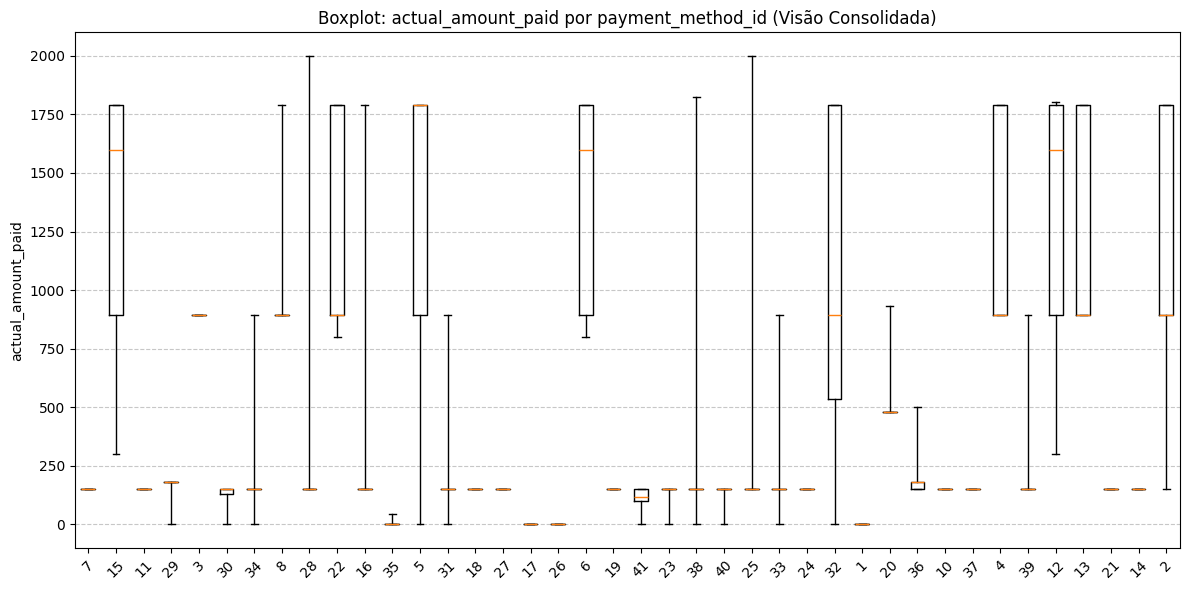

In [42]:
plot_boxplot(df_transactions, ["payment_method_id"], "actual_amount_paid", agrupar_por_safra=False)

Processando estatísticas para: payment_method_id...


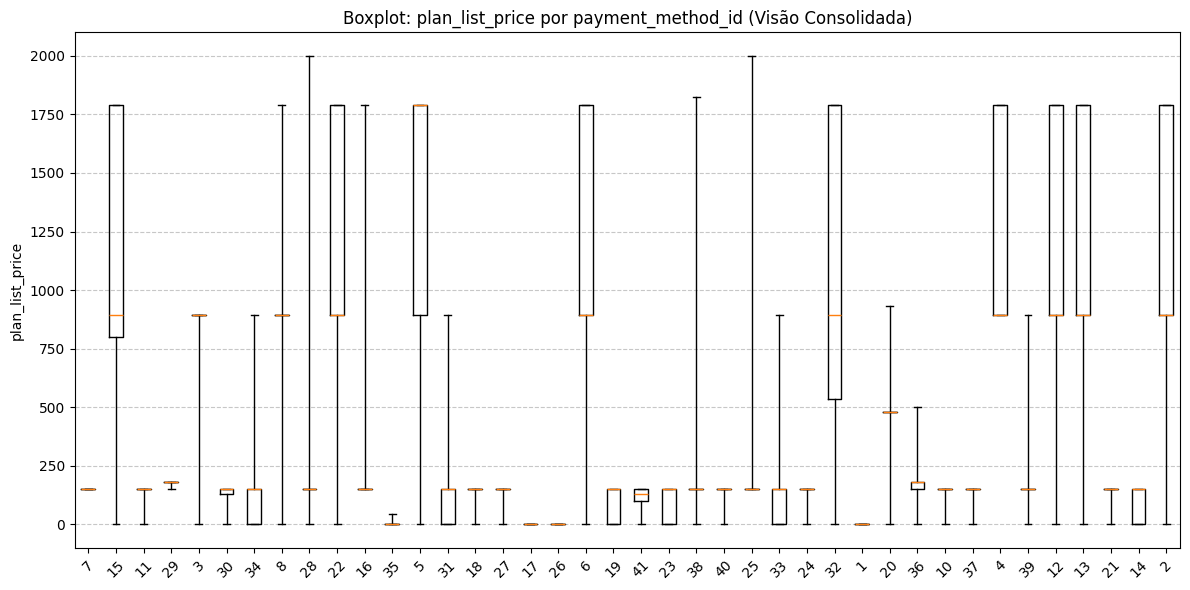

In [44]:
plot_boxplot(df_transactions, ["payment_method_id"], "plan_list_price", agrupar_por_safra=False)

IQR (Interquartile Range) mede a dispersão do “miolo” da distribuição, ignorando outliers extremos.

IQR pequeno → valores concentrados

IQR grande → valores espalhados

Dois métodos podem ter:

IQR = 50

Mas:

Método A: mediana = 100 → variação enorme

Método B: mediana = 1000 → variação pequena

👉 `iqr_rel` mede variabilidade proporcional, não absoluta.

Isso permite comparar métodos baratos e caros na mesma escala.

Conceito estatístico: por que IQR? Por que não média e desvio padrão?

* Média é puxada por outliers
* Desvio padrão explode em distribuições assimétricas
* Preços e pagamentos não são normais

Por que IQR?
* Robusto a outliers
* Reflete comportamento típico
* Muito usado em análise exploratória e boxplots

In [14]:
stats_pm = (df_transactions
    .groupBy("payment_method_id")
    .agg(
        F.expr("percentile_approx(actual_amount_paid, 0.25)").alias("q1"),
        F.expr("percentile_approx(actual_amount_paid, 0.75)").alias("q3"),
        F.expr("percentile_approx(actual_amount_paid, 0.5)").alias("median"))
    .withColumn("iqr", F.col("q3") - F.col("q1"))
    .withColumn("iqr_rel",
        F.when(F.col("median") > 0, F.col("iqr") / F.col("median"))
        .otherwise(F.lit(0)))
)

In [15]:
IQR_FIXO = 1e-6 # IQR proximo a zero: Todos os pagamentos têm o mesmo valor
IQR_REL_BAIXO = 0.25 # Até 25% de variação relativa é considerado “estável”: 50% central dos dados varia no máximo ±12.5% da mediana
MEDIANA_ALTA = 500 # Baseado no que foi visto nos graficos boxplot, parece razoável considerar alta a mediana acima de 500

In [20]:
stats_pm = stats_pm.withColumn("payment_method_price_profile",
    F.when(F.col("iqr") <= IQR_FIXO, "fixo")
    .when((F.col("iqr_rel") <= IQR_REL_BAIXO) & (F.col("median") < MEDIANA_ALTA), "baixo_estavel")
    .when((F.col("iqr_rel") <= IQR_REL_BAIXO) & (F.col("median") >= MEDIANA_ALTA), "alto_estavel")
    .when((F.col("iqr_rel") > IQR_REL_BAIXO) & (F.col("median") < MEDIANA_ALTA), "misto_baixo")
    .otherwise("misto_alto"))

In [21]:
df_transactions_enriched = (df_transactions
    .join(
        stats_pm.select("payment_method_id", "payment_method_price_profile"),
        on="payment_method_id",
        how="left")
)

#### Agrupamento de métodos de pagamento por perfil de preço (IQR)

Neste projeto, os métodos de pagamento foram agrupados com base na variabilidade
do valor efetivamente pago (`actual_amount_paid`), utilizando a métrica robusta
Interquartile Range (IQR). Essa abordagem permite identificar métodos associados
a preços fixos, planos estáveis de baixo valor, planos estáveis de alto valor
e métodos com alta heterogeneidade de cobrança.

Optou-se por utilizar o valor efetivamente pago em vez do preço de tabela
(`plan_list_price`), pois a margem líquida é diretamente impactada pela receita
real recebida, incorporando efeitos de descontos, promoções e campanhas
comerciais. O preço de tabela foi mantido como variável complementar, pois
representa a política comercial e o tipo estrutural de plano contratado.

O agrupamento foi construído exclusivamente com variáveis disponíveis no momento
da transação, garantindo viabilidade de implantação em produção e evitando
target leakage.

Target leakage ocorre quando informações que só estariam disponíveis após o
evento a ser previsto (como consumo futuro ou margem líquida no mês seguinte)
são utilizadas durante o treinamento do modelo, resultando em métricas
artificialmente otimistas e modelos inviáveis em cenários reais.

Dessa forma, o agrupamento de métodos de pagamento é tratado como uma feature
estática de lookup, reduzindo dimensionalidade, controlando variância e
aumentando interpretabilidade, sem introduzir viés indevido na modelagem.


Processando estatísticas para: payment_method_price_profile...


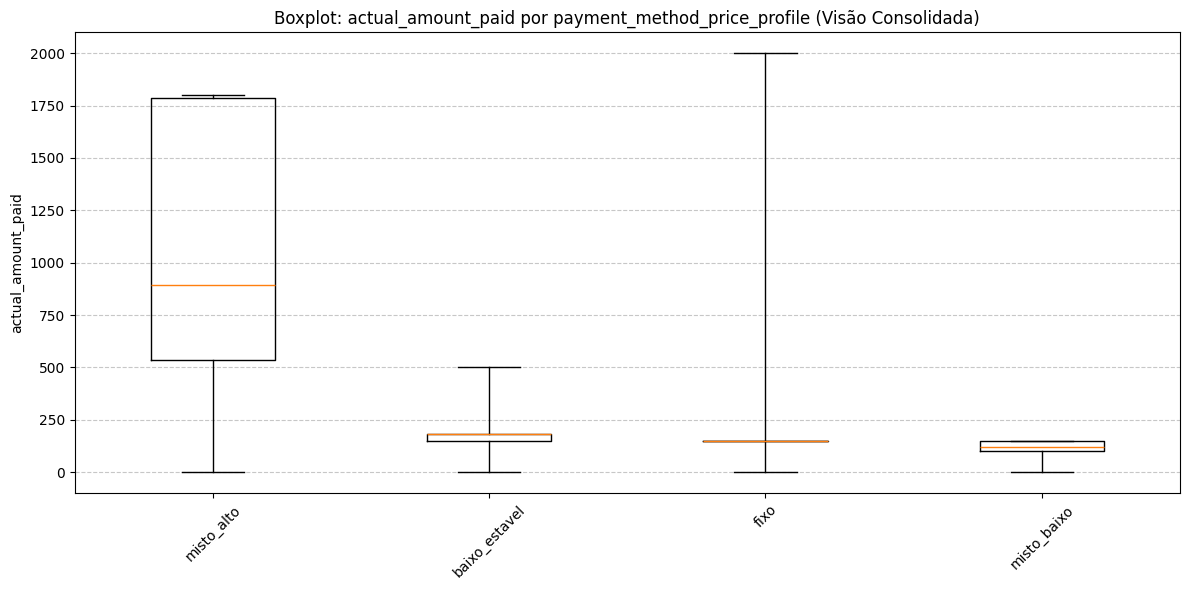

In [22]:
plot_boxplot(df_transactions_enriched, ["payment_method_price_profile"], "actual_amount_paid", agrupar_por_safra=False)

In [23]:
calcular_distribuicao(df_transactions_enriched, ["payment_method_price_profile"], n_show=10, agrupar_por_safra=False)

+----------------------------+--------+---------+
|payment_method_price_profile|total   |pct_total|
+----------------------------+--------+---------+
|misto_baixo                 |11026911|53.24    |
|fixo                        |8541108 |41.24    |
|baixo_estavel               |967633  |4.67     |
|misto_alto                  |176573  |0.85     |
+----------------------------+--------+---------+



DataFrame[payment_method_price_profile: string, total: bigint, pct_total: double]

#### Agrupamento de métodos de pagamento por perfil de preço

Com base na variabilidade e na escala do valor efetivamente pago
(`actual_amount_paid`), os métodos de pagamento foram agrupados em
quatro perfis distintos, utilizando métricas robustas (IQR e mediana)
e apenas informações disponíveis no momento da transação, garantindo
viabilidade de implantação em produção e ausência de target leakage.

#### Definição dos grupos

**1. Fixo**
Métodos de pagamento com valor de cobrança praticamente constante,
caracterizados por IQR próximo de zero. Representam planos ou políticas
com preço único e rígido, nos quais a grande maioria das transações ocorre
em um valor específico, com raros desvios pontuais.
Esses métodos apresentam alta previsibilidade de receita e baixo risco
de variação na margem.

**2. Baixo Estável**
Métodos associados a valores baixos de cobrança, com variabilidade
relativa controlada. A mediana do valor pago é baixa e o IQR relativo
indica estabilidade no preço típico, refletindo planos básicos ou
mensais com pouca influência de promoções.
Esse grupo apresenta comportamento consistente e boa interpretabilidade
para modelos lineares.

**3. Misto Baixo**
Métodos de pagamento com valor típico baixo, porém com maior
heterogeneidade. Embora a maioria das transações ocorra em valores
reduzidos, existem eventos ocasionais de cobrança mais elevada,
indicando uso do mesmo método para diferentes contextos comerciais,
como upgrades pontuais ou campanhas específicas.
Esse grupo concentra o maior volume de transações e apresenta maior
variância de comportamento.

**4. Misto Alto**
Métodos caracterizados por valores típicos elevados e alta variabilidade.
A mediana do valor pago é alta e a dispersão é significativa, indicando
uso irregular do método para planos premium, renovações longas ou
operações específicas de alto valor.
Apesar do baixo volume, esse grupo é relevante para análise de risco e
impacto na margem, pois concentra transações com grande influência
financeira.

#### Conclusão

A subdivisão do grupo heterogêneo em perfis de preço baixo e alto
permitiu capturar diferenças relevantes de escala e comportamento de
cobrança, sem aumentar excessivamente a complexidade do modelo.
O resultado final equilibra interpretabilidade, controle de variância
e aderência ao contexto de negócio, tornando o agrupamento adequado
para uso como feature explicativa em modelos de previsão de margem
líquida.


### is_cancel

In [ ]:
is_cancel_general = calcular_distribuicao(df_transactions, "is_cancel")
is_cancel_per_safra = calcular_distribuicao(df_transactions, "is_cancel", agrupar_por_safra=True)

+---------+--------+---------+
|is_cancel|   total|pct_total|
+---------+--------+---------+
|        0|20031271|    96.71|
|        1|  680954|     3.29|
+---------+--------+---------+

+------+---------+------+---------+---------+
| safra|is_cancel| total|pct_safra|pct_total|
+------+---------+------+---------+---------+
|201501|        0|528398|    96.28|     2.55|
|201501|        1| 20394|     3.72|      0.1|
|201502|        0|528952|     97.0|     2.55|
|201502|        1| 16351|      3.0|     0.08|
|201503|        0|608867|    97.19|     2.94|
|201503|        1| 17621|     2.81|     0.09|
|201504|        0|545598|    96.64|     2.63|
|201504|        1| 18984|     3.36|     0.09|
|201505|        0|549342|    96.11|     2.65|
|201505|        1| 22210|     3.89|     0.11|
+------+---------+------+---------+---------+
only showing top 10 rows



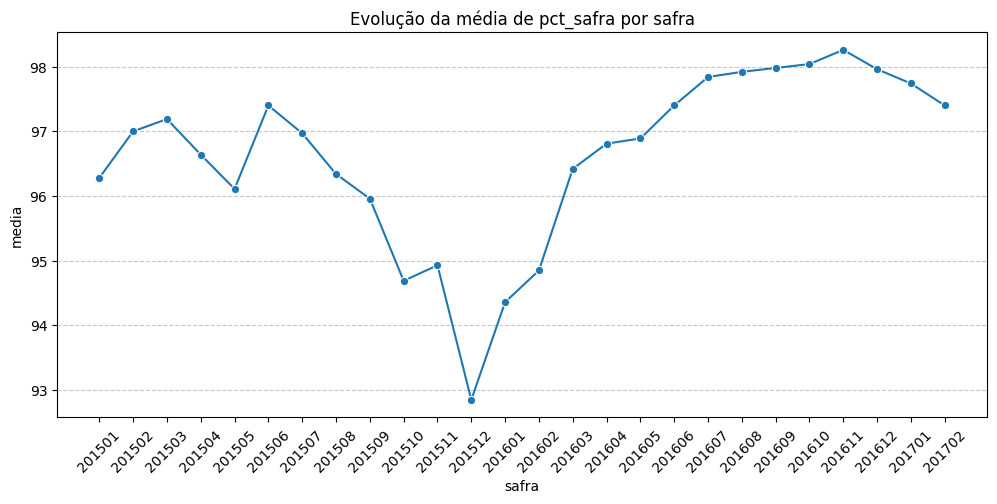

In [ ]:
plot_tendencia_temporal(is_cancel_per_safra.filter(F.col("is_cancel").isin([0])), "pct_safra")

In [ ]:
is_cancel_per_safra.filter(F.col("is_cancel").isin([0])).groupBy("is_cancel").agg(F.mean("pct_safra").alias("media_ativos")).orderBy("is_cancel").show(20)

+---------+-----------------+
|is_cancel|     media_ativos|
+---------+-----------------+
|        0|96.62423076923079|
+---------+-----------------+



Aproximadamente 96,62% de todos os registros tem plano ativo. Todos eles sao clientes presentes na tabela members?

In [23]:
calcular_distribuicao(df_transactions.filter(F.col("is_cancel") == 1), ["actual_amount_paid"], n_show=20)

+------------------+------+---------+
|actual_amount_paid|total |pct_total|
+------------------+------+---------+
|149               |367676|53.99    |
|0                 |233580|34.3     |
|99                |42775 |6.28     |
|129               |20907 |3.07     |
|180               |13207 |1.94     |
|119               |941   |0.14     |
|100               |901   |0.13     |
|120               |826   |0.12     |
|134               |125   |0.02     |
|131               |14    |0.0      |
|41                |1     |0.0      |
|894               |1     |0.0      |
+------------------+------+---------+



DataFrame[actual_amount_paid: string, total: bigint, pct_total: double]

In [25]:
calcular_distribuicao(df_transactions.filter(F.col("is_cancel") == 1), ["plan_list_price", "actual_amount_paid"], n_show=20)

+---------------+------------------+------+---------+
|plan_list_price|actual_amount_paid|total |pct_total|
+---------------+------------------+------+---------+
|149            |149               |357834|52.55    |
|149            |0                 |228592|33.57    |
|99             |99                |42772 |6.28     |
|129            |129               |20553 |3.02     |
|180            |180               |13207 |1.94     |
|0              |149               |9822  |1.44     |
|0              |0                 |4294  |0.63     |
|100            |100               |897   |0.13     |
|120            |120               |826   |0.12     |
|120            |0                 |694   |0.1      |
|119            |119               |679   |0.1      |
|149            |119               |257   |0.04     |
|0              |129               |244   |0.04     |
|134            |134               |117   |0.02     |
|149            |129               |110   |0.02     |
|119            |149        

DataFrame[plan_list_price: string, actual_amount_paid: string, total: bigint, pct_total: double]

Aparentemente e possivel pagar e cancelar, bem como nao pagar e tambem cancelar.

### is_auto_renew

In [46]:
is_auto_renew_general = calcular_distribuicao(df_transactions, "is_auto_renew")
is_auto_renew_per_safra = calcular_distribuicao(df_transactions, ["is_auto_renew"], agrupar_por_safra=True)

+-------------+--------+---------+
|is_auto_renew|total   |pct_total|
+-------------+--------+---------+
|1            |17696175|85.44    |
|0            |3016050 |14.56    |
+-------------+--------+---------+

+------+-------------+------+---------+---------+
|safra |is_auto_renew|total |pct_safra|pct_total|
+------+-------------+------+---------+---------+
|201501|1            |480841|87.62    |2.32     |
|201501|0            |67951 |12.38    |0.33     |
|201502|1            |478828|87.81    |2.31     |
|201502|0            |66475 |12.19    |0.32     |
|201503|1            |552320|88.16    |2.67     |
|201503|0            |74168 |11.84    |0.36     |
|201504|1            |484295|85.78    |2.34     |
|201504|0            |80287 |14.22    |0.39     |
|201505|1            |484227|84.72    |2.34     |
|201505|0            |87325 |15.28    |0.42     |
+------+-------------+------+---------+---------+
only showing top 10 rows



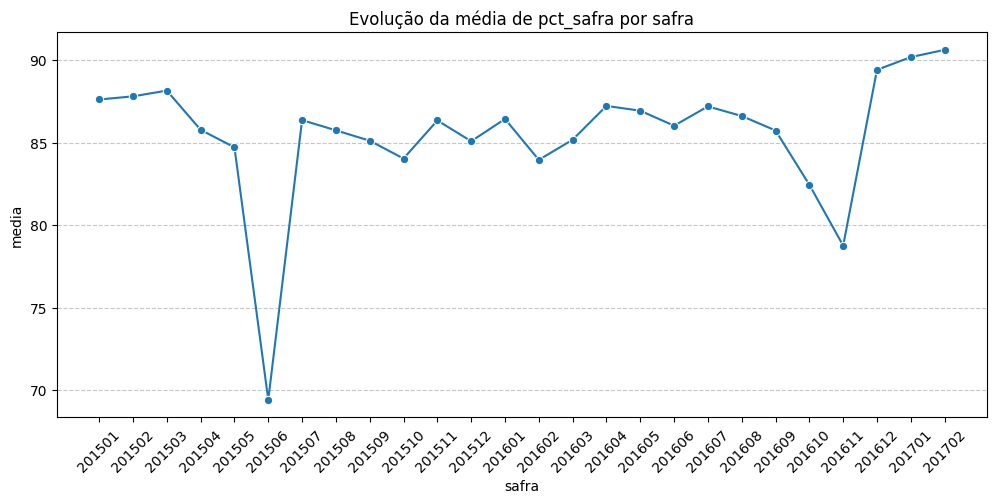

In [48]:
plot_tendencia_temporal(is_auto_renew_per_safra.filter(F.col("is_auto_renew").isin([1])), "pct_safra")

In [50]:
is_auto_renew_per_safra.filter(F.col("is_auto_renew").isin([1])).groupBy("is_auto_renew").agg(F.mean("pct_safra").alias("media_auto_renew")).orderBy("is_auto_renew").show(20)

+-------------+-----------------+
|is_auto_renew| media_auto_renew|
+-------------+-----------------+
|            1|85.50038461538462|
+-------------+-----------------+



Aproximadamente 85,5% de todos os registros tem auto renovacao ativa.

### payment_plan_days

In [64]:
calcular_distribuicao(df_transactions, "payment_plan_days", agrupar_por_safra=False)

+-----------------+--------+---------+
|payment_plan_days|total   |pct_total|
+-----------------+--------+---------+
|30               |18251936|88.12    |
|0                |848204  |4.1      |
|31               |743859  |3.59     |
|7                |517635  |2.5      |
|195              |107816  |0.52     |
|410              |78425   |0.38     |
|180              |51019   |0.25     |
|100              |23828   |0.12     |
|10               |22538   |0.11     |
|90               |11518   |0.06     |
+-----------------+--------+---------+
only showing top 10 rows



DataFrame[payment_plan_days: int, total: bigint, pct_total: double]

#### Agrupando tipo de plano

In [16]:
df_transactions = df_transactions.withColumn("payment_plan_days", F.col("payment_plan_days").cast("int"))

# 1. Categorização de Grupos de Compromisso
df_trans_analise = df_transactions.withColumn("grupo_plano", 
    F.when(F.col("payment_plan_days") < 30, "01. Curto Prazo (<30d)")
     .when(F.col("payment_plan_days").isin(30, 31), "02. Mensal (30-31d)")
     .when(F.col("payment_plan_days") > 31, "03. Longo Prazo (>31d)")
     .otherwise("04. Indefinido"))

# 2. Agregação de Métricas de Negócio
resumo_planos = df_trans_analise.groupBy("grupo_plano").agg(
    F.count("msno").alias("total_transacoes"),
    F.round((F.count("msno") / F.lit(total_transactions)) * 100, 2).alias("pct_transacoes"),
    F.round(F.avg("plan_list_price"), 2).alias("valor_plano_medio"),
    F.round(F.avg("actual_amount_paid"), 2).alias("valor_pago_medio"),
    # Calculando o valor proporcional por dia
    F.round(F.avg(F.col("actual_amount_paid") / F.when(F.col("payment_plan_days") == 0, 1).otherwise(F.col("payment_plan_days"))), 2).alias("ticket_diario_medio"),
    F.round(F.avg("is_auto_renew").cast(DecimalType(20, 10)) * 100, 4).alias("pct_auto_renovacao"),
    F.round(F.avg("is_cancel").cast(DecimalType(20, 10)) * 100, 4).alias("pct_cancelamento")
).orderBy("grupo_plano")

resumo_planos.show(truncate=False)

+----------------------+----------------+--------------+-----------------+----------------+-------------------+------------------+----------------+
|grupo_plano           |total_transacoes|pct_transacoes|valor_plano_medio|valor_pago_medio|ticket_diario_medio|pct_auto_renovacao|pct_cancelamento|
+----------------------+----------------+--------------+-----------------+----------------+-------------------+------------------+----------------+
|01. Curto Prazo (<30d)|1398223         |6.75          |0.16             |96.2            |96.06              |56.5530           |1.0283          |
|02. Mensal (30-31d)   |18995795        |91.71         |136.1            |131.86          |4.39               |88.9957           |3.5091          |
|03. Longo Prazo (>31d)|318207          |1.54          |1002.81          |1002.81         |4.18               |0.0000            |0.0003          |
+----------------------+----------------+--------------+-----------------+----------------+-------------------+-

Validacao

In [ ]:
(df_trans_analise
    .groupBy("grupo_plano")
    .agg(
        F.min("payment_plan_days").alias("min_days"),
        F.max("payment_plan_days").alias("max_days"),
        F.countDistinct("payment_plan_days").alias("qtd_variacoes"))
    .orderBy("min_days")
    .show(10, truncate=False)
)

+----------------------+--------+--------+-------------+
|grupo_plano           |min_days|max_days|qtd_variacoes|
+----------------------+--------+--------+-------------+
|01. Curto Prazo (<30d)|0       |21      |9            |
|02. Mensal (30-31d)   |30      |31      |2            |
|03. Longo Prazo (>31d)|35      |450     |26           |
+----------------------+--------+--------+-------------+



#### Análise de "Planos de Valor Zero"

Nenhum valor cobrado e nenhum valor pago

In [ ]:
df_trans_analise\
    .filter(
        (F.col("plan_list_price").isin(0))
        & (F.col("actual_amount_paid").isin(0))
    )\
    .orderBy("safra").show(20, truncate=False)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+------------+-------------+----------------------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |payment_diff|flag_pag_diff|grupo_plano           |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+------------+-------------+----------------------+
|GDPa9EDrpnRz7wfV0NCQFzDSE6sBJGuAMK2wqAgMpew=|26               |1                |0              |0                 |0            |20150115        |20151230              |0        |201501|0.0         |0            |01. Curto Prazo (<30d)|
|V+A5DGD+6JVAmRaJqzrKLiPSxkZzIMrvV4hILmTgDpE

In [ ]:
df_trans_analise\
    .filter(
        (F.col("plan_list_price").isin(0))
        & (F.col("actual_amount_paid").isin(0))
        & (F.col("msno").isin("S99dhoZY9eJG1GKNPkQ27C+pR9HgZNUpWf1qRYs4P8g="))
    )\
    .orderBy("safra").show(20, truncate=False)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+------------+-------------+----------------------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |payment_diff|flag_pag_diff|grupo_plano           |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+------------+-------------+----------------------+
|S99dhoZY9eJG1GKNPkQ27C+pR9HgZNUpWf1qRYs4P8g=|38               |180              |0              |0                 |0            |20150121        |20150720              |0        |201501|0.0         |0            |03. Longo Prazo (>31d)|
+-------------------------------------------

In [ ]:
trans_contagem = df_trans_analise.filter((F.col("plan_list_price").isin(0)) & (F.col("actual_amount_paid").isin(0))).groupBy('msno').agg(F.count('*').alias('contagem'))
trans_contagem.select("contagem").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "99.5%", "max").show()

+-------+------------------+
|summary|          contagem|
+-------+------------------+
|  count|            529090|
|   mean|1.0625167740838042|
| stddev|0.3081890497067433|
|    min|                 1|
|    25%|                 1|
|    50%|                 1|
|    75%|                 1|
|  99.5%|                 3|
|    max|                 9|
+-------+------------------+



O P75 mostra que os casos de transacoes gratis ocorreram apenas uma vez

In [ ]:
df_trans_analise.filter((F.col("plan_list_price").isin(0)) & (F.col("actual_amount_paid").isin(0))).groupBy("safra")\
    .agg(
        F.count("msno").alias("total_transacoes_gratis"),
        F.round((F.count("msno") / F.lit(total_transactions)) * 100, 4).alias("pct_transacoes_gratis"))\
    .show(20, truncate=False)

+------+-----------------------+---------------------+
|safra |total_transacoes_gratis|pct_transacoes_gratis|
+------+-----------------------+---------------------+
|201505|8693                   |0.042                |
|201702|2162                   |0.0104               |
|201701|5017                   |0.0242               |
|201501|218                    |0.0011               |
|201509|4916                   |0.0237               |
|201609|38849                  |0.1876               |
|201512|15880                  |0.0767               |
|201604|476                    |0.0023               |
|201511|5626                   |0.0272               |
|201611|140203                 |0.6769               |
|201502|338                    |0.0016               |
|201503|451                    |0.0022               |
|201603|3838                   |0.0185               |
|201508|2569                   |0.0124               |
|201607|27497                  |0.1328               |
|201610|83

#### Mudanca de estado ao longo do tempo

In [68]:
verificar_mudanca_estado(df_transactions, col_alvo="payment_plan_days", visualizar=True)

Contagem de mudanças por safra:
+------+-----+------+
|safra |mudou|count |
+------+-----+------+
|201502|true |4004  |
|201503|true |6221  |
|201504|true |181046|
|201505|true |413728|
|201506|true |227428|
|201507|true |25546 |
|201508|true |10998 |
|201509|true |12293 |
|201510|true |12146 |
|201511|true |81854 |
|201512|true |18349 |
|201601|true |11426 |
|201602|true |21723 |
|201603|true |9835  |
|201604|true |8628  |
|201605|true |8805  |
|201606|true |9314  |
|201607|true |21309 |
|201608|true |19260 |
|201609|true |18395 |
|201610|true |23665 |
|201611|true |27820 |
|201612|true |13091 |
|201701|true |9067  |
|201702|true |8013  |
+------+-----+------+

Mudanças por usuário:
+--------------------------------------------+--------------+
|msno                                        |total_mudancas|
+--------------------------------------------+--------------+
|++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=|2             |
|++6P09mCSJSh+Ft2pvZ0FWTrtcI3v1A7h3/coh8dBKw=|2            

In [70]:
verificar_mudanca_estado(df_trans_analise, col_alvo="grupo_plano", visualizar=True)

Contagem de mudanças por safra:
+------+-----+------+
|safra |mudou|count |
+------+-----+------+
|201502|true |2700  |
|201503|true |4438  |
|201504|true |179306|
|201505|true |381153|
|201506|true |216546|
|201507|true |24698 |
|201508|true |9665  |
|201509|true |10626 |
|201510|true |10558 |
|201511|true |80158 |
|201512|true |15418 |
|201601|true |9507  |
|201602|true |18518 |
|201603|true |7882  |
|201604|true |7288  |
|201605|true |7328  |
|201606|true |8080  |
|201607|true |19614 |
|201608|true |17680 |
|201609|true |16751 |
|201610|true |22028 |
|201611|true |26474 |
|201612|true |12589 |
|201701|true |8735  |
|201702|true |7744  |
+------+-----+------+

Mudanças por usuário:
+--------------------------------------------+--------------+
|msno                                        |total_mudancas|
+--------------------------------------------+--------------+
|++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=|2             |
|++6P09mCSJSh+Ft2pvZ0FWTrtcI3v1A7h3/coh8dBKw=|2            

In [72]:
df_trans_analise.filter(F.col("msno").isin("+/H9aTMCulY64Kzq7YxYXXoPnVgGk0nc/p0S9dwUQ+g=")).select("msno", "safra", "payment_plan_days", "grupo_plano").orderBy("safra").show(20, truncate=False)

+--------------------------------------------+------+-----------------+----------------------+
|msno                                        |safra |payment_plan_days|grupo_plano           |
+--------------------------------------------+------+-----------------+----------------------+
|+/H9aTMCulY64Kzq7YxYXXoPnVgGk0nc/p0S9dwUQ+g=|201501|31               |02. Mensal (30-31d)   |
|+/H9aTMCulY64Kzq7YxYXXoPnVgGk0nc/p0S9dwUQ+g=|201502|31               |02. Mensal (30-31d)   |
|+/H9aTMCulY64Kzq7YxYXXoPnVgGk0nc/p0S9dwUQ+g=|201503|31               |02. Mensal (30-31d)   |
|+/H9aTMCulY64Kzq7YxYXXoPnVgGk0nc/p0S9dwUQ+g=|201504|0                |01. Curto Prazo (<30d)|
|+/H9aTMCulY64Kzq7YxYXXoPnVgGk0nc/p0S9dwUQ+g=|201505|30               |02. Mensal (30-31d)   |
|+/H9aTMCulY64Kzq7YxYXXoPnVgGk0nc/p0S9dwUQ+g=|201506|30               |02. Mensal (30-31d)   |
|+/H9aTMCulY64Kzq7YxYXXoPnVgGk0nc/p0S9dwUQ+g=|201507|30               |02. Mensal (30-31d)   |
|+/H9aTMCulY64Kzq7YxYXXoPnVgGk0nc/p0S9dwUQ+g=|2015

In [74]:
df_trans_analise.filter(F.col("msno").isin("+/H9aTMCulY64Kzq7YxYXXoPnVgGk0nc/p0S9dwUQ+g=")).orderBy("safra").show(20, truncate=False)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+------------+-------------+----------------------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |payment_diff|flag_pag_diff|grupo_plano           |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+------------+-------------+----------------------+
|+/H9aTMCulY64Kzq7YxYXXoPnVgGk0nc/p0S9dwUQ+g=|40               |31               |149            |0                 |1            |20150124        |20150223              |0        |201501|-149.0      |1            |02. Mensal (30-31d)   |
|+/H9aTMCulY64Kzq7YxYXXoPnVgGk0nc/p0S9dwUQ+g

In [75]:
df_trans_analise.filter(F.col("msno").isin("++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=")).orderBy("safra").show(20, truncate=False)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+------------+-------------+----------------------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |payment_diff|flag_pag_diff|grupo_plano           |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+------------+-------------+----------------------+
|++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=|41               |30               |129            |129               |1            |20150113        |20150213              |0        |201501|0.0         |0            |02. Mensal (30-31d)   |
|++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U

Suspeita:
* Casos em que o cliente pagou (`actual_amount_paid` <> 0) mas nao veio cobranca (`plan_list_prize` == 0), marca `payment_plan_days` = 0.
* Casos em que o cliente nao paga (`actual_amount_paid` == 0) mas veio cobranca (`plan_list_prize` <> 0), marca `is_cancel` = 1.

In [20]:
calcular_distribuicao(df_trans_analise.filter((~F.col("actual_amount_paid").isin(0)) & (F.col("plan_list_price").isin(0))), ["payment_plan_days"])

+-----------------+------+---------+
|payment_plan_days|total |pct_total|
+-----------------+------+---------+
|0                |837847|100.0    |
|180              |2     |0.0      |
+-----------------+------+---------+



DataFrame[payment_plan_days: int, total: bigint, pct_total: double]

In [19]:
calcular_distribuicao(df_trans_analise.filter((F.col("actual_amount_paid").isin(0)) & (~F.col("plan_list_price").isin(0))), ["is_cancel"])

+---------+------+---------+
|is_cancel|total |pct_total|
+---------+------+---------+
|0        |256390|52.79    |
|1        |229286|47.21    |
+---------+------+---------+



DataFrame[is_cancel: string, total: bigint, pct_total: double]

In [21]:
calcular_distribuicao(df_trans_analise.filter((F.col("actual_amount_paid").isin(0)) & (F.col("is_cancel").isin(0))), ["plan_list_price"])

+---------------+------+---------+
|plan_list_price|total |pct_total|
+---------------+------+---------+
|0              |557873|68.51    |
|149            |255957|31.43    |
|180            |266   |0.03     |
|120            |165   |0.02     |
|699            |2     |0.0      |
+---------------+------+---------+



DataFrame[plan_list_price: string, total: bigint, pct_total: double]

A análise revelou que `payment_plan_days` = 0 representa um estado administrativo de ausência de cobrança, e não um plano de curta duração. Além disso, ciclos sem pagamento não correspondem necessariamente a cancelamentos, indicando a existência de isenções e falhas de cobrança. Com base nisso, no processo de *feature engineering* devo distinguir explicitamente estados de cobrança, utilizando `payment_plan_days` apenas em ciclos válidos de cobrança e introduzindo flags específicas para isenção e falha de cobrança, reduzindo ruído e viés estrutural no modelo.

Levar para feature engineering:

In [ ]:
df = df.withColumn("flag_cobranca_valida", # Para construcao do grupo_plano_final, portanto, nao precisa inserir na base final
    F.when((F.col("payment_plan_days") > 0) & (F.col("plan_list_price") > 0), 1)\
    .otherwise(0))

df = df.withColumn("flag_sem_cobranca",
    F.when(F.col("payment_plan_days") == 0, 1).otherwise(0))

df = df.withColumn("flag_isencao",
    F.when(
        (F.col("actual_amount_paid") == 0) &
        (F.col("plan_list_price") == 0) &
        (F.col("is_cancel") == 0), 1)\
    .otherwise(0))

df = df.withColumn(
    "flag_falha_cobranca",
    F.when(
        (F.col("actual_amount_paid") == 0) &
        (F.col("plan_list_price") > 0) &
        (F.col("is_cancel") == 0), 1)\
    .otherwise(0))

df = df.withColumn("flag_cancelamento",
    F.when(F.col("is_cancel") == 1, 1).otherwise(0))

In [ ]:
df = df.withColumn("grupo_plano_final",
    F.when(F.col("flag_cobranca_valida") == 0, "00. Sem Cobranca")
    .when(F.col("payment_plan_days") < 30, "01. Curto Prazo")
    .when(F.col("payment_plan_days").isin(30, 31), "02. Mensal")
    .when(F.col("payment_plan_days") > 31, "03. Longo Prazo"))

O `payment_plan_days` só é interpretado como tipo de plano quando existe cobrança válida (`payment_plan_days > 0` e `plan_list_price > 0`). Casos fora dessa condição representam estados administrativos do ciclo, como isenção, falha de cobrança ou ausência de cobrança. Para evitar ruído e viés estrutural no modelo, foram criadas flags específicas que distinguem esses estados, permitindo que o modelo aprenda separadamente comportamento de plano e eventos excepcionais.


Apesar do aumento no número de variáveis binárias, as flags criadas representam estados mutuamente exclusivos do ciclo de cobrança e refletem regras de negócio reais. Esse tipo de feature engineering reduz ambiguidade semântica, melhora interpretabilidade e diminui viés estrutural, sendo preferível ao uso direto de variáveis contínuas que misturam múltiplos fenômenos.


Mais sugestoes para Feature Engineering:

1. daily_revenue_efficiency (Eficiência de Receita Diária)
Significado: É a normalização do valor pago pelo tempo de serviço. Ela responde: "Quantos NTD este cliente deixa na mesa por cada dia de acesso?"
Impacto no Modelo: Como o custo operacional possui um componente diário (tempo em segundos), esta métrica permite comparar se um plano de 410 dias é proporcionalmente mais barato para a empresa do que um plano de 30 dias. É a variável fundamental para identificar o "lucro bruto diário" antes da subtração do custo de logs.

2. revenue_stability_index (Índice de Estabilidade de Receita)Significado: Um score que combina a duração do plano com o comportamento de renovação automática (is_auto_renew)6.Score 2 (Alta): Usuários que ou já pagaram por um longo período ou estão no débito automático mensal.Score 1 (Média): Usuários mensais que precisam tomar a ação manual de pagar todo mês.Score 0 (Baixa): Usuários de pacotes curtos e eventuais.Impacto no Modelo: Ajuda a estimar a volatilidade da margem. Planos de estabilidade 2 têm uma variância muito menor na previsão de rentabilidade para o mês seguinte ($M+1$)

In [ ]:
df = df.withColumn("daily_revenue_efficiency",
    F.when(F.col("flag_cobranca_valida").isin(1), F.col("actual_amount_paid") / F.col("payment_plan_days")))

df = df.withColumn("revenue_stability_index",
    F.when((F.col("grupo_plano_final").isin("03. Longo Prazo")) & (F.col("is_auto_renew").isin(1)), 2)  # Alta estabilidade
    .when((F.col("grupo_plano_final").isin("02. Mensal")) & (F.col("is_auto_renew").isin(1)), 1)  # Média estabilidade
    .otherwise(0))  # Baixa ou inexistente

### actual_amount_paid

In [5]:
df_transactions = df_transactions.withColumn("actual_amount_paid", F.col("actual_amount_paid").cast("float"))

In [6]:
df_transactions.select("actual_amount_paid").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show()

+-------+------------------+
|summary|actual_amount_paid|
+-------+------------------+
|  count|          20712225|
|   mean|142.83468555406287|
| stddev|133.60944276809502|
|    min|               0.0|
|    25%|              99.0|
|    50%|             149.0|
|    75%|             149.0|
|    max|            2000.0|
+-------+------------------+



In [7]:
df_transactions.groupBy("actual_amount_paid").count().orderBy(F.desc("actual_amount_paid")).show()

+------------------+------+
|actual_amount_paid| count|
+------------------+------+
|            2000.0|   119|
|            1825.0|     2|
|            1802.0|     1|
|            1800.0|     1|
|            1799.0|     1|
|            1788.0| 82809|
|            1599.0| 11991|
|            1520.0|    13|
|            1200.0|  5313|
|            1150.0|    95|
|            1000.0|   741|
|             930.0|  5063|
|             894.0|111410|
|             890.0|     1|
|             849.0|     1|
|             800.0|    11|
|             799.0|  6422|
|             760.0|     2|
|             699.0|   887|
|             600.0|     3|
+------------------+------+
only showing top 20 rows



In [13]:
((df_transactions.filter(F.col("actual_amount_paid") > 149).count()) / (df_transactions.count())) * 100

6.521515674921454

Por representar aproximadamente 6,5% do total de transacoes, talvez faca sentido considerar como ponto de alavancagem e remover?

PENDENTE: aplicar a formula para capturar casos de alavancagem e ver se a quantidade diminui. O filtro atual considera apenas o valor mais comum ate 75% dos dados ordenados.

### membership_expire_date

In [36]:
calcular_distribuicao(df_transactions, "membership_expire_date")

+----------------------+------+---------+
|membership_expire_date|total |pct_total|
+----------------------+------+---------+
|20150615              |173138|0.84     |
|20170228              |129307|0.62     |
|20161031              |127679|0.62     |
|20161130              |127035|0.61     |
|20160831              |125082|0.6      |
|20170131              |124755|0.6      |
|20160930              |123540|0.6      |
|20161231              |122891|0.59     |
|20160229              |115762|0.56     |
|20170331              |112799|0.54     |
+----------------------+------+---------+
only showing top 10 rows



DataFrame[membership_expire_date: string, total: bigint, pct_total: double]

In [37]:
df_transactions_anl = (df_transactions
    .withColumn("membership_expire_date", F.to_date(F.col("membership_expire_date"), "yyyyMMdd"))
    .withColumn("membership_expire_year_month", F.date_format(F.col("membership_expire_date"), "yyyyMM").cast("int"))
)

In [41]:
calcular_distribuicao(df_transactions_anl, "membership_expire_year_month")

+----------------------------+-------+---------+
|membership_expire_year_month|total  |pct_total|
+----------------------------+-------+---------+
|201611                      |1129184|5.45     |
|201612                      |1013338|4.89     |
|201609                      |1006833|4.86     |
|201702                      |1004932|4.85     |
|201701                      |1001690|4.84     |
|201610                      |997294 |4.82     |
|201703                      |997231 |4.81     |
|201603                      |860866 |4.16     |
|201608                      |858715 |4.15     |
|201601                      |829898 |4.01     |
+----------------------------+-------+---------+
only showing top 10 rows



DataFrame[membership_expire_year_month: int, total: bigint, pct_total: double]

In [38]:
df_transactions_anl.select("membership_expire_year_month").summary("count", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+----------------------------+
|summary|membership_expire_year_month|
+-------+----------------------------+
|  count|                    20712225|
|    min|                      197001|
|     1%|                      201502|
|    10%|                      201505|
|    25%|                      201510|
|    50%|                      201605|
|    75%|                      201610|
|    95%|                      201702|
|  99.5%|                      201703|
|    max|                      201703|
+-------+----------------------------+



In [30]:
df_transactions_anl.filter(F.col("membership_expire_year_month") < "201501").groupBy("membership_expire_year_month").count().show(10, truncate=False)

+----------------------------+-----+
|membership_expire_year_month|count|
+----------------------------+-----+
|201402                      |147  |
|201302                      |69   |
|201303                      |356  |
|201305                      |147  |
|201309                      |196  |
|201406                      |190  |
|201312                      |216  |
|201403                      |166  |
|201211                      |7    |
|201311                      |222  |
+----------------------------+-----+
only showing top 10 rows



In [32]:
df_transactions_anl.filter(F.col("membership_expire_year_month") < "201501").select("msno", "safra", "membership_expire_year_month", "transaction_date").show(10, truncate=False)

+--------------------------------------------+------+----------------------------+----------------+
|msno                                        |safra |membership_expire_year_month|transaction_date|
+--------------------------------------------+------+----------------------------+----------------+
|+3UG/uRcLrwhCK0LtHqdmoHO5NLlZJzY+OG33pufSjE=|201512|201310                      |20151223        |
|+ZoXRYo4IxvYq2xYPivjn9qug+dTHdNPveEttAzX6oM=|201501|201411                      |20150127        |
|+oMJt7y1ez1nsOhmUj6928jafEs3Vt4C8d6UFpzfIG8=|201512|201408                      |20151223        |
|+q4cNHUod+HpoCTlIOFZHfYdb6eSUr9oHzJplVeiy6s=|201501|201412                      |20150123        |
|/GUW0qZoq/CQ+ygEqOghsOU90f4FtIsS6HHpVKMeJxE=|201512|201303                      |20151224        |
|/RkH5ZwSeKPPAqmWIBBbfc31HnC7FQJDzwFY2sCRsg0=|201507|197001                      |20150706        |
|/f3tTQOEzDOD79J4CGZ4k4PA5lInD94qVK4t39VdJ/U=|201512|201302                      |20151223        |


Menos de 1% da base tem membership_expire_date menor do que jan/2015. Sugestao para feature engineering: construir flag expire_date_valida

### transaction_date

In [42]:
calcular_distribuicao(df_transactions, "transaction_date")

+----------------+------+---------+
|transaction_date|total |pct_total|
+----------------+------+---------+
|20160831        |203233|0.98     |
|20161031        |202971|0.98     |
|20160930        |199635|0.96     |
|20160731        |198135|0.96     |
|20161130        |196293|0.95     |
|20161231        |196158|0.95     |
|20170131        |193562|0.93     |
|20160131        |192898|0.93     |
|20150831        |183190|0.88     |
|20150331        |179309|0.87     |
+----------------+------+---------+
only showing top 10 rows



DataFrame[transaction_date: string, total: bigint, pct_total: double]

In [33]:
df_transactions_anl = (df_transactions
    .withColumn("transaction_date", F.to_date(F.col("transaction_date"), "yyyyMMdd"))
    .withColumn("transaction_date_year_month", F.date_format(F.col("transaction_date"), "yyyyMM").cast("int"))
)

In [44]:
calcular_distribuicao(df_transactions_anl, "transaction_date_year_month")

+---------------------------+-------+---------+
|transaction_date_year_month|total  |pct_total|
+---------------------------+-------+---------+
|201611                     |1094941|5.29     |
|201610                     |1033898|4.99     |
|201701                     |988576 |4.77     |
|201609                     |982640 |4.74     |
|201612                     |968547 |4.68     |
|201608                     |966450 |4.67     |
|201607                     |924032 |4.46     |
|201702                     |885566 |4.28     |
|201512                     |861107 |4.16     |
|201601                     |856716 |4.14     |
+---------------------------+-------+---------+
only showing top 10 rows



DataFrame[transaction_date_year_month: int, total: bigint, pct_total: double]

In [35]:
df_transactions_anl.select("transaction_date_year_month").summary("count", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+---------------------------+
|summary|transaction_date_year_month|
+-------+---------------------------+
|  count|                   20712225|
|    min|                     201501|
|     1%|                     201501|
|    10%|                     201504|
|    25%|                     201509|
|    50%|                     201603|
|    75%|                     201609|
|    95%|                     201701|
|  99.5%|                     201702|
|    max|                     201702|
+-------+---------------------------+



Aparentemente nao tem problemas na data de transacao. Sugestao para feature engineering com a data de expiracao de membro:

In [ ]:
df = df.withColumn("months_to_expire",
    F.when(F.col("membership_expire_year_month") >= 201501,
        (F.col("membership_expire_year_month") - F.col("transaction_date_year_month"))))

A data de expiração da assinatura apresenta valores inconsistentes anteriores ao início da base (<201501), representando menos de 1% dos registros e indicando ruído estrutural ou valores default de sistema. Para evitar viés, esses casos foram identificados por uma flag específica. A informação de expiração foi transformada em uma variável relativa ao momento da transação (meses até a expiração), que é causal, interpretável e adequada para uso em modelos preditivos.


## Analise Especifica de Tabela: members

### dictionary

Definition: User information. Note that not every user in the dataset is available.

* msno
* city
* bd: age. Note: this column has outlier values ranging 
from -7000 to 2015, please use your judgement.
* gender
* registered_via: registration method
* registration_init_time: format %Y%m%d




### general info

In [86]:
total_members = df_members.count()
total_members

63867246

In [87]:
df_members.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: string (nullable = true)
 |-- registration_init_time: string (nullable = true)
 |-- city: string (nullable = true)
 |-- bd: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- registered_via: string (nullable = true)
 |-- is_ativo: integer (nullable = true)



In [11]:
df_members.show(10, truncate=False)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|201612|20140927              |1   |0  |NULL  |7             |1       |
|++/AwGzubug3gT6J+0STBGMdWKxaM+UFZTI8Tcmq4To=|201607|20150322              |1   |0  |NULL  |9             |0       |
|++/Gw1B9K+XOlB3hLTloeUK2QlCa2m+BJ8TrzGf7djI=|201601|20121217              |15  |32 |male  |3             |1       |
|++02XbtviomSxcIBUHMOiJkjRxdicTXSfiVqLdsr5lo=|201603|20131112              |14  |21 |male  |7             |0       |
|++0O0Bq04sB/9ZcOS+pajpYL2Hin9jCqnc/8bKzKFuE=|201610|20141021              |5   |33 |male  |3             |0       |
|++2AQgVgYUAqJDw684tbDqDffUeKhqydyQmbr8lz9lQ=|201608|20150416   

#### Duplicatas e aparicoes

In [46]:
print("Número de duplicatas encontradas: " + str(verificar_duplicatas(df_members)))

Número de duplicatas encontradas: 0


In [28]:
members_contagem = df_members.groupBy('msno').agg(F.count('*').alias('contagem'))
members_contagem.select("contagem").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "99.5%", "max").show()

+-------+------------------+
|summary|          contagem|
+-------+------------------+
|  count|           6287789|
|   mean|10.157345610674913|
| stddev| 3.242783103114158|
|    min|                 1|
|    25%|                 9|
|    50%|                12|
|    75%|                12|
|  99.5%|                12|
|    max|                12|
+-------+------------------+



In [51]:
contagem_members = members_contagem.count()
calcular_distribuicao(members_contagem, "contagem", contagem_members, col_id="contagem", n_show=20)

+--------+-------+---------+
|contagem|  total|pct_total|
+--------+-------+---------+
|      12|4294184|    68.29|
|      11| 208170|     3.31|
|      10| 195618|     3.11|
|       7| 189359|     3.01|
|       6| 189273|     3.01|
|       8| 184404|     2.93|
|       9| 178329|     2.84|
|       5| 176584|     2.81|
|       1| 173444|     2.76|
|       3| 170302|     2.71|
|       2| 165057|     2.63|
|       4| 163065|     2.59|
+--------+-------+---------+



In [30]:
contagem_safra_members = df_members.select("safra").distinct().count()
print(f"O número de safras na base é: {contagem_safra_members}")

O número de safras na base é: 12


### tipagem

In [88]:
df_members = (df_members
              .withColumn("bd", F.col("bd").cast("integer"))
              .withColumn("is_ativo", F.col("is_ativo").cast("integer"))
              .withColumn("registered_via", F.col("registered_via").cast("integer")))

### registered_via

In [89]:
calcular_distribuicao(df_members, ["registered_via"], n_show=25)

+--------------+--------+---------+
|registered_via|total   |pct_total|
+--------------+--------+---------+
|4             |19648219|30.76    |
|3             |18640987|29.19    |
|9             |16776651|26.27    |
|7             |8407395 |13.16    |
|11            |269614  |0.42     |
|8             |47588   |0.07     |
|5             |18715   |0.03     |
|2             |16847   |0.03     |
|16            |10564   |0.02     |
|13            |7546    |0.01     |
|14            |7111    |0.01     |
|17            |6630    |0.01     |
|19            |5629    |0.01     |
|6             |3380    |0.01     |
|1             |254     |0.0      |
|10            |104     |0.0      |
|-1            |12      |0.0      |
+--------------+--------+---------+



DataFrame[registered_via: int, total: bigint, pct_total: double]

Pendente: verificar na margem liquida as estatisticas para cada categoria e entao agrupar

### bd --> idade

In [90]:
calcular_distribuicao(df_members, ["bd"], n_show=25)

+---+--------+---------+
|bd |total   |pct_total|
+---+--------+---------+
|0  |39509864|61.86    |
|22 |1220332 |1.91     |
|21 |1196188 |1.87     |
|20 |1183935 |1.85     |
|27 |1136339 |1.78     |
|23 |1109043 |1.74     |
|24 |1066096 |1.67     |
|26 |1027742 |1.61     |
|25 |1010945 |1.58     |
|18 |961760  |1.51     |
|19 |955064  |1.5      |
|28 |926093  |1.45     |
|29 |920441  |1.44     |
|17 |838237  |1.31     |
|30 |792655  |1.24     |
|32 |726893  |1.14     |
|31 |705358  |1.1      |
|33 |659476  |1.03     |
|34 |624997  |0.98     |
|37 |605437  |0.95     |
|35 |595797  |0.93     |
|36 |575431  |0.9      |
|38 |478553  |0.75     |
|39 |432434  |0.68     |
|16 |401278  |0.63     |
+---+--------+---------+
only showing top 25 rows



DataFrame[bd: int, total: bigint, pct_total: double]

In [91]:
df_members.select("bd").summary("count", "mean", "stddev", "min", "1%", "25%", "50%", "75%", "99.5%", "max").show()

+-------+------------------+
|summary|                bd|
+-------+------------------+
|  count|          63867246|
|   mean|11.430160210759675|
| stddev|19.041318387984273|
|    min|             -7168|
|     1%|                 0|
|    25%|                 0|
|    50%|                 0|
|    75%|                24|
|  99.5%|                61|
|    max|              2016|
+-------+------------------+



In [99]:
print("Percentual do total da base: " + str((df_members.filter(F.col("bd").between(0, 61)).count()) / (total_members) * 100) + "%")
df_members.filter(F.col("bd").between(0, 61)).select("bd").summary("count", "mean", "stddev", "min", "1%", "25%", "50%", "75%", "99%", "max").show()

Percentual do total da base: 99.5290089696368%
+-------+------------------+
|summary|                bd|
+-------+------------------+
|  count|          63566437|
|   mean|11.090138605692182|
| stddev|15.397906043029254|
|    min|                 0|
|     1%|                 0|
|    25%|                 0|
|    50%|                 0|
|    75%|                24|
|    99%|                52|
|    max|                61|
+-------+------------------+



In [100]:
print("Percentual do total da base: " + str((df_members.filter(F.col("bd").between(1, 61)).count()) / (total_members) * 100) + "%")
df_members.filter(F.col("bd").between(1, 61)).select("bd").summary("count", "mean", "stddev", "min", "1%", "25%", "50%", "75%", "99%", "max").show()

Percentual do total da base: 37.6665262817188%
+-------+------------------+
|summary|                bd|
+-------+------------------+
|  count|          24056573|
|   mean|29.304281910810822|
| stddev| 9.630283475662145|
|    min|                 1|
|     1%|                16|
|    25%|                22|
|    50%|                27|
|    75%|                35|
|    99%|                56|
|    max|                61|
+-------+------------------+



Dado que o P1 da variavel (removendo os zeros e maiores de 61) é 16 + o fato de que serviços de assinatura digital frequentemente adotam 13 ou 16 anos como idade mínima por questões de conformidade com leis de proteção de dados (LGPD), 16 anos foi decidido como idade minima permitida.

In [103]:
print("Porcentagem de usuarios com idade igual a 0:", (df_members.filter(F.col("bd").isin(0)).count() / total_members) * 100)
print("Porcentagem de usuarios com idade menor do que 0:", (df_members.filter(F.col("bd") < 0).count() / total_members) * 100)
print("Porcentagem de usuarios com idade entre 1 e 60 anos:", (df_members.filter(F.col("bd").between(1, 60)).count() / total_members) * 100)
print("Porcentagem de usuarios com idade entre 61 e 80 anos:", (df_members.filter(F.col("bd").between(61, 80)).count() / total_members) * 100)
print("Porcentagem de usuarios com idade maior do que 80 anos:", (df_members.filter(F.col("bd") > 80).count() / total_members) * 100)

Porcentagem de usuarios com idade igual a 0: 61.862482687917996
Porcentagem de usuarios com idade menor do que 0: 0.004819371732421342
Porcentagem de usuarios com idade entre 1 e 60 anos: 37.61010455969872
Porcentagem de usuarios com idade entre 61 e 80 anos: 0.37236457635890546
Porcentagem de usuarios com idade maior do que 80 anos: 0.1502288042919527


In [107]:
identificar_outliers(df_members, "bd", negativo=False)

Variável bd:
Limites: [0, 57.5]
Total de outliers (#): 470971
Total de outliers (%): 0.74%


In [108]:
identificar_outliers(df_members, "bd", negativo=False, minimo_definido=16)

Variável bd:
Limites: [16, 57.5]
Total de outliers (#): 40166084
Total de outliers (%): 62.89%


Como qualquer tratamento atrelaria um viés na dataprep, entendo que seja melhor trabalhar com agrupamentos, classificando outliers como "Desconhecido".

In [109]:
df_members_teste = df_members.withColumn("faixa_etaria",
    F.when(F.col("bd").between(16, 21), "01.Adolescente")\
    .when(F.col("bd").between(22, 35), "02.Jovem Adulto")\
    .when(F.col("bd").between(36, 50), "03.Adulto")\
    .when(F.col("bd").between(51, 61), "04.Meia Idade")\
    .otherwise("05.Desconhecido"))

In [110]:
calcular_distribuicao(df_members_teste, "faixa_etaria")

+---------------+--------+---------+
|faixa_etaria   |total   |pct_total|
+---------------+--------+---------+
|05.Desconhecido|39995922|62.62    |
|02.Jovem Adulto|12522207|19.61    |
|01.Adolescente |5536462 |8.67     |
|03.Adulto      |4951923 |7.75     |
|04.Meia Idade  |860732  |1.35     |
+---------------+--------+---------+



DataFrame[faixa_etaria: string, total: bigint, pct_total: double]

### gender

In [112]:
calcular_distribuicao(df_members, ["gender"], n_show=5)

+------+--------+---------+
|gender|total   |pct_total|
+------+--------+---------+
|NULL  |38210177|59.83    |
|male  |13075425|20.47    |
|female|12581644|19.7     |
+------+--------+---------+



DataFrame[gender: string, total: bigint, pct_total: double]

In [19]:
gender_per_safra = calcular_distribuicao(df_members, ["gender"], n_show=100, agrupar_por_safra=True)

+------+------+-------+---------+---------+
|safra |gender|total  |pct_safra|pct_total|
+------+------+-------+---------+---------+
|201601|NULL  |2290971|53.35    |3.59     |
|201601|male  |1018241|23.71    |1.59     |
|201601|female|984972 |22.94    |1.54     |
|201602|NULL  |2469561|54.85    |3.87     |
|201602|male  |1034270|22.97    |1.62     |
|201602|female|998523 |22.18    |1.56     |
|201603|NULL  |2639013|56.17    |4.13     |
|201603|male  |1048445|22.32    |1.64     |
|201603|female|1010514|21.51    |1.58     |
|201604|NULL  |2793991|57.3     |4.37     |
|201604|male  |1060627|21.75    |1.66     |
|201604|female|1021683|20.95    |1.6      |
|201605|NULL  |2955526|58.4     |4.63     |
|201605|male  |1072726|21.2     |1.68     |
|201605|female|1032453|20.4     |1.62     |
|201606|NULL  |3120875|59.44    |4.89     |
|201606|male  |1085229|20.67    |1.7      |
|201606|female|1043960|19.88    |1.63     |
|201607|NULL  |3285146|60.4     |5.14     |
|201607|male  |1098063|20.19    

In [20]:
gender_per_safra = gender_per_safra.withColumn("gender", F.when(F.col("gender").isNull(), "unknown").otherwise(F.col("gender")))

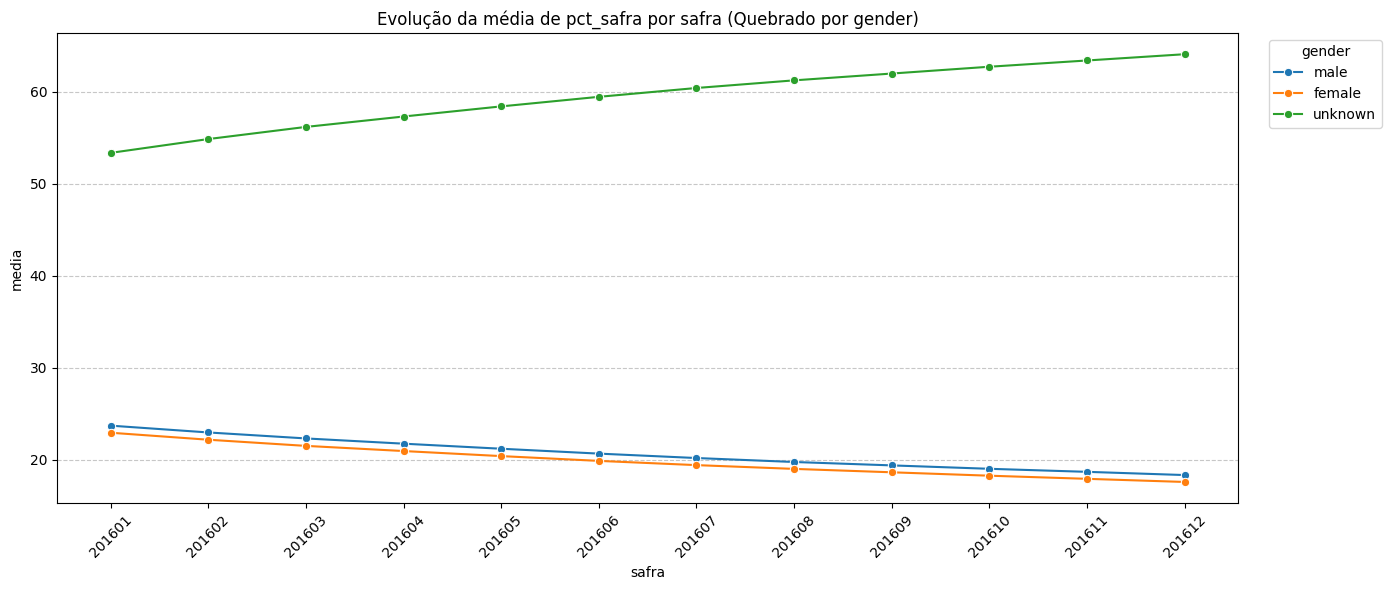

In [21]:
plot_tendencia_temporal(gender_per_safra, col_valor="pct_safra", categories="gender")

In [22]:
verificar_mudanca_estado(df_members, "gender", visualizar=True)

Contagem de mudanças por safra:
+-----+-----+-----+
|safra|mudou|count|
+-----+-----+-----+
+-----+-----+-----+

Mudanças por usuário:
+----+--------------+
|msno|total_mudancas|
+----+--------------+
+----+--------------+



Pendente: verificar margem liquida por categoria. Ideia: separar numa possivel variavel binaria `gender_registered` --> pessoas com genero cadastrado tem maior/menor margem liquida do que as que nao tem este cadastro?

### city

In [23]:
calcular_distribuicao(df_members, "city")

+----+--------+---------+
|city|total   |pct_total|
+----+--------+---------+
|1   |41955263|65.69    |
|5   |4271348 |6.69     |
|13  |3650065 |5.72     |
|4   |2730740 |4.28     |
|22  |2328925 |3.65     |
|15  |2123349 |3.32     |
|6   |1492818 |2.34     |
|14  |1004416 |1.57     |
|12  |740584  |1.16     |
|9   |538369  |0.84     |
+----+--------+---------+
only showing top 10 rows



DataFrame[city: string, total: bigint, pct_total: double]

Pendente: checar valores de margem liquida para ver como fazer o agrupamento entre cidades.

Ideia possivel tambem: criar uma categorica binaria: cidade 1 ou nao.

#### Checando transicoes de cidade

In [24]:
verificar_mudanca_estado(df_members, "city", visualizar=True)

Contagem de mudanças por safra:
+-----+-----+-----+
|safra|mudou|count|
+-----+-----+-----+
+-----+-----+-----+

Mudanças por usuário:
+----+--------------+
|msno|total_mudancas|
+----+--------------+
+----+--------------+



### registration_init_time

In [11]:
df_members.select("registration_init_time").distinct().count()

4663

In [14]:
df_members.select("registration_init_time").summary("count", "min", "max").show()

+-------+----------------------+
|summary|registration_init_time|
+-------+----------------------+
|  count|              63867246|
|    min|              20040326|
|    max|              20161231|
+-------+----------------------+



Sao muitas e diversas datas de registro, as quais vao de 26/03/2004 ate 31/12/2016. Checar agrupamento por ANO, ANOMES, talvez ANOMESSEMANA

In [ ]:
df_registration_init_time = (df_members
                             .select("msno", "registration_init_time")
                             .withColumn("ano_registration", F.year(F.to_date(F.col("registration_init_time").cast("string"), "yyyyMMdd"))))

df_registration_init_time.groupBy("ano_registration").agg(
    F.count("msno").alias("total_members"),
    F.round((F.count("msno") / F.lit(total_members)) * 100, 2).alias("pct_total")
).orderBy(("ano_registration")).show(50)

+----------------+-------------+---------+
|ano_registration|total_members|pct_total|
+----------------+-------------+---------+
|            2004|       314808|     0.49|
|            2005|       496188|     0.78|
|            2006|       647436|     1.01|
|            2007|      1077960|     1.69|
|            2008|       812280|     1.27|
|            2009|       763596|      1.2|
|            2010|      1380900|     2.16|
|            2011|      2148612|     3.36|
|            2012|      3398280|     5.32|
|            2013|      6296664|     9.86|
|            2014|     11709312|    18.33|
|            2015|     19446300|    30.45|
|            2016|     15374910|    24.07|
+----------------+-------------+---------+



Possiveis agregacoes:

In [25]:
df_registration_init_time = df_registration_init_time.withColumn("ano_registration_final", F.when(
    F.col("ano_registration") <= 2010, F.lit("2004-2010")).otherwise(F.col("ano_registration")))

df_registration_init_time.groupBy("ano_registration_final").agg(
    F.count("msno").alias("total_members"),
    F.round((F.count("msno") / F.lit(total_members)) * 100, 2).alias("pct_total")
).orderBy(("ano_registration_final")).show(50)

+----------------------+-------------+---------+
|ano_registration_final|total_members|pct_total|
+----------------------+-------------+---------+
|             2004-2010|      5493168|      8.6|
|                  2011|      2148612|     3.36|
|                  2012|      3398280|     5.32|
|                  2013|      6296664|     9.86|
|                  2014|     11709312|    18.33|
|                  2015|     19446300|    30.45|
|                  2016|     15374910|    24.07|
+----------------------+-------------+---------+



In [24]:
df_registration_init_time = df_registration_init_time.withColumn("ano_registration_final", F.when(
    F.col("ano_registration") <= 2013, F.lit("2004-2013")).otherwise(F.col("ano_registration")))

df_registration_init_time.groupBy("ano_registration_final").agg(
    F.count("msno").alias("total_members"),
    F.round((F.count("msno") / F.lit(total_members)) * 100, 2).alias("pct_total")
).orderBy(("ano_registration_final")).show(50)

+----------------------+-------------+---------+
|ano_registration_final|total_members|pct_total|
+----------------------+-------------+---------+
|             2004-2013|     17336724|    27.14|
|                  2014|     11709312|    18.33|
|                  2015|     19446300|    30.45|
|                  2016|     15374910|    24.07|
+----------------------+-------------+---------+



In [23]:
df_registration_init_time = df_registration_init_time.withColumn("ano_registration_final",
    F.when(F.col("ano_registration") <= 2011, F.lit("2004-2011"))\
    .when(F.col("ano_registration").isin(2012, 2013), F.lit("2012-2013"))
    .otherwise(F.col("ano_registration")))

df_registration_init_time.groupBy("ano_registration_final").agg(
    F.count("msno").alias("total_members"),
    F.round((F.count("msno") / F.lit(total_members)) * 100, 2).alias("pct_total")
).orderBy(("ano_registration_final")).show(50)

+----------------------+-------------+---------+
|ano_registration_final|total_members|pct_total|
+----------------------+-------------+---------+
|             2004-2011|      7641780|    11.97|
|             2012-2013|      9694944|    15.18|
|                  2014|     11709312|    18.33|
|                  2015|     19446300|    30.45|
|                  2016|     15374910|    24.07|
+----------------------+-------------+---------+



Pendente: verificar margem liquida para cada ano de registro e capturar informacoes para melhor agrupamento.

### is_ativo

In [28]:
calcular_distribuicao(df_members, ["is_ativo"])
calcular_distribuicao(df_members, ["is_ativo"], agrupar_por_safra=True)

+--------+--------+---------+
|is_ativo|total   |pct_total|
+--------+--------+---------+
|0       |52624381|82.4     |
|1       |11242865|17.6     |
+--------+--------+---------+

+------+--------+-------+---------+---------+
|safra |is_ativo|total  |pct_safra|pct_total|
+------+--------+-------+---------+---------+
|201601|0       |3405521|79.31    |5.33     |
|201601|1       |888663 |20.69    |1.39     |
|201602|0       |3584238|79.61    |5.61     |
|201602|1       |918116 |20.39    |1.44     |
|201603|0       |3826321|81.45    |5.99     |
|201603|1       |871651 |18.55    |1.36     |
|201604|0       |4044736|82.95    |6.33     |
|201604|1       |831565 |17.05    |1.3      |
|201605|0       |4211052|83.21    |6.59     |
|201605|1       |849653 |16.79    |1.33     |
+------+--------+-------+---------+---------+
only showing top 10 rows



DataFrame[safra: string, is_ativo: int, total: bigint, pct_safra: double, pct_total: double]

Vou usar, basicamente, somente 17,6% do dataframe, dado que o foco preciso ser no publico ativo.

## Relacao entre tabelas

### tabela members + logs

In [74]:
integridade_entre_bases(df_members, df_logs, "Membros x Logs")

--- Integridade: Membros x Logs ---
Registros na base: 63867246 | Registros correspondentes: 13103573
Taxa de Perda: 79.48%



In [26]:
integridade_entre_bases(df_members.filter(F.col("is_ativo").isin(1)), df_logs, "Membros ativos x Logs")

--- Integridade: Membros ativos x Logs ---
Registros na base: 11242865 | Registros correspondentes: 9975880
Taxa de Perda: 11.27%



In [28]:
df_atv_members_logs = df_members.filter(F.col("is_ativo").isin(1)).join(df_logs, on=["msno", "safra"], how="inner")

#### registered_via

In [31]:
df_atv_members_logs = df_atv_members_logs.withColumn("direct_cost", (50 + (0.0051 * F.col("num_unq")) + (0.0001 * F.col("total_secs"))))

In [33]:
df_atv_members_logs = aplicar_winsorizacao(df_atv_members_logs, ["direct_cost"])

Coluna direct_cost: Limite Inferior=50.035880999999996, Limite Superior=153.4409162


Processando estatísticas para: registered_via...


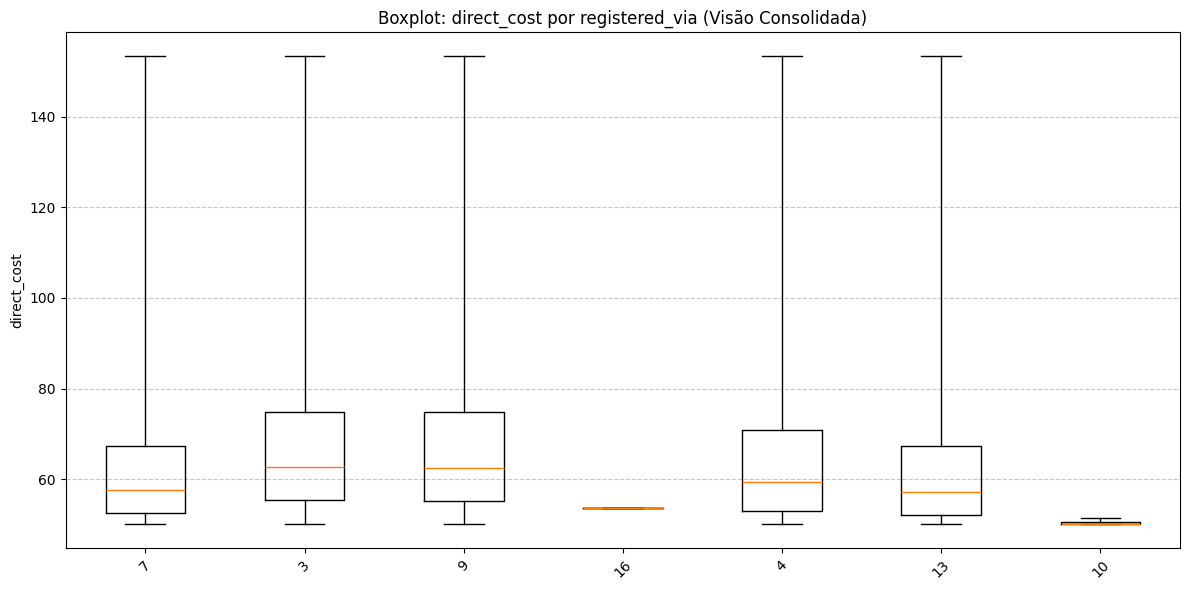

In [34]:
plot_boxplot(df_atv_members_logs, ["registered_via"], "direct_cost", agrupar_por_safra=False)

In [35]:
calcular_distribuicao(df_atv_members_logs, ["registered_via"], n_show=25)

+--------------+-------+---------+
|registered_via|total  |pct_total|
+--------------+-------+---------+
|7             |4320557|43.31    |
|9             |3477122|34.86    |
|3             |1585188|15.89    |
|4             |586714 |5.88     |
|13            |6293   |0.06     |
|10            |5      |0.0      |
|16            |1      |0.0      |
+--------------+-------+---------+



DataFrame[registered_via: string, total: bigint, pct_total: double]

Possibilidade de agrupar pela similaridade de mediana, criando uma flag binaria (mediana acima e abaixo de 60). No entanto, faz sentido eu fazer isso baseado no custo, que compoe a target? Entendo que nao, porque caracteriza de algum modo target leakage.

Coluna total_secs: Limite Inferior=245.213, Limite Superior=898842.2079999999
Processando estatísticas para: registered_via...


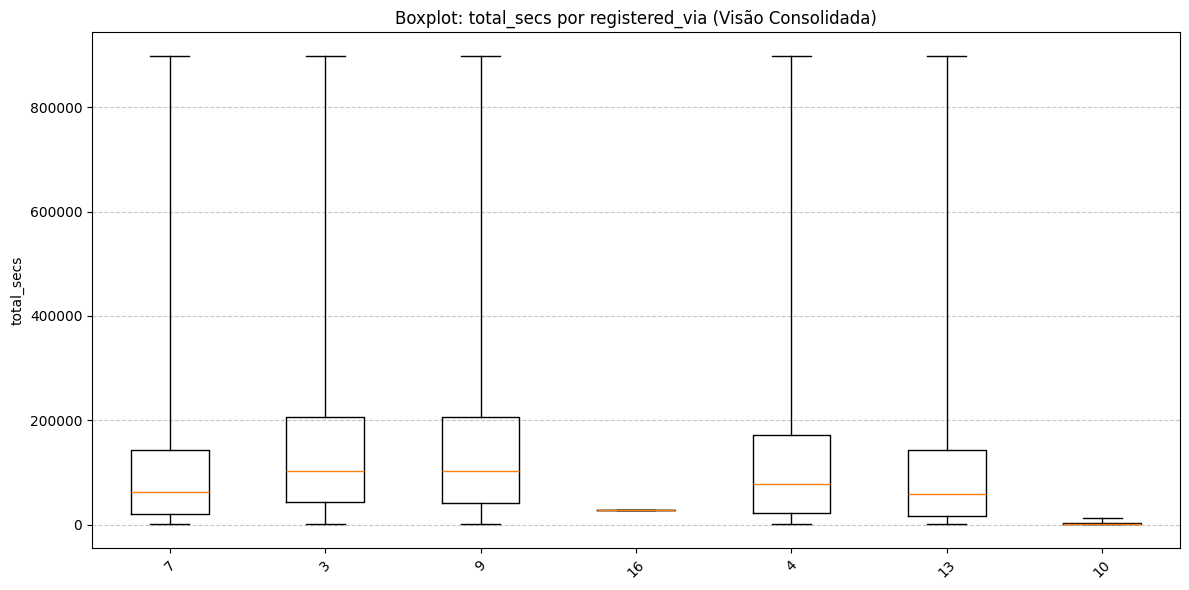

In [36]:
df_atv_members_logs = aplicar_winsorizacao(df_atv_members_logs, ["total_secs"])
plot_boxplot(df_atv_members_logs, ["registered_via"], "total_secs", agrupar_por_safra=False)

Coluna num_unq: Limite Inferior=2.0, Limite Superior=2888.0
Processando estatísticas para: registered_via...


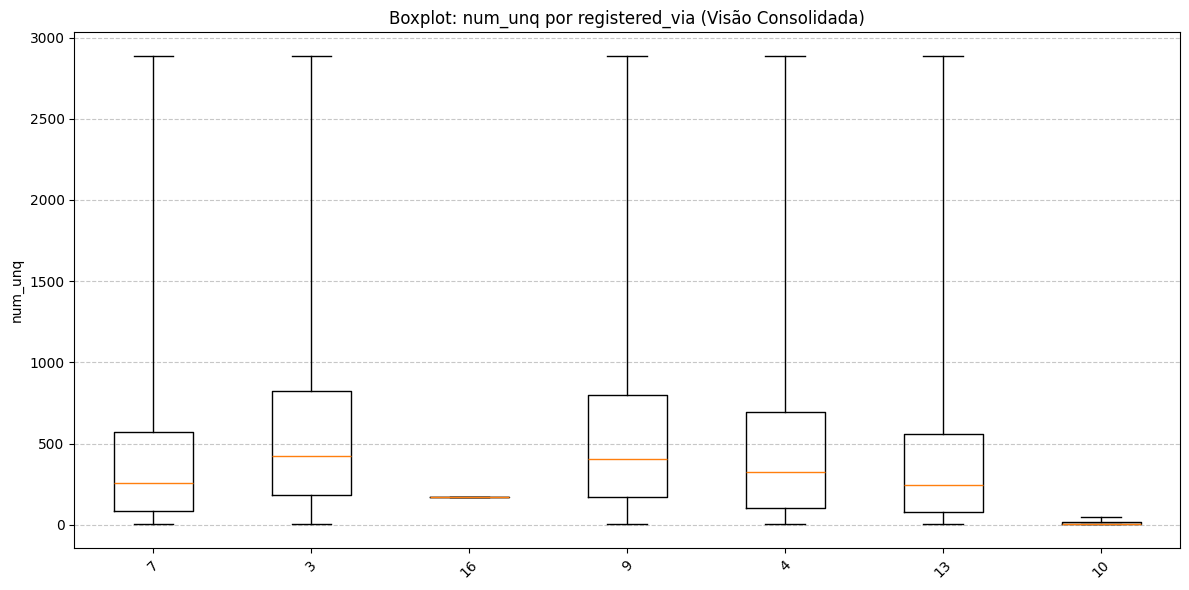

In [37]:
df_atv_members_logs = aplicar_winsorizacao(df_atv_members_logs, ["num_unq"])
plot_boxplot(df_atv_members_logs, ["registered_via"], "num_unq", agrupar_por_safra=False)

### tabela members + transactions

In [73]:
integridade_entre_bases(df_members, df_transactions, "Membros x Transações")

--- Integridade: Membros x Transações ---
Registros na base: 63867246 | Registros correspondentes: 9390483
Taxa de Perda: 85.30%



In [27]:
integridade_entre_bases(df_members.filter(F.col("is_ativo").isin(1)), df_transactions, "Membros ativos x Transações")

--- Integridade: Membros ativos x Transações ---
Registros na base: 11242865 | Registros correspondentes: 9390483
Taxa de Perda: 16.48%



### tabela logs + transactions

In [57]:
integridade_entre_bases(df_logs, df_transactions, "Logs x Transações")

--- Integridade: Logs x Transações ---
Registros na base: 26758971 | Registros correspondentes: 16160111
Taxa de Perda: 39.61%



In [13]:
df_logs_transactions = df_logs.join(df_transactions, on=["msno", "safra"], how="full_outer")

In [16]:
df_logs_transactions.show(30, truncate=False)

+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|
+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|201509|375.0 |73.0  |46.0  |43.0   |631.0  |1041.0 |180656.804        |41               |30               |149            |149               |1            |20150926        |20151026              

In [ ]:
df_logs.filter(F.col("total_secs").isNull()).show(10, truncate=False)

+----+-----+------+------+------+-------+-------+-------+----------+
|msno|safra|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+----+-----+------+------+------+-------+-------+-------+----------+
+----+-----+------+------+------+-------+-------+-------+----------+



In [18]:
df_transactions.filter(F.col("is_auto_renew").isNull()).show(10, truncate=False)

+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+
|msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra|
+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+
+----+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----+



In [30]:
df_logs_transactions = (df_logs_transactions
    .withColumn("flag_logs", F.when(F.col("total_secs").isNotNull(), 1).otherwise(0))
    .withColumn("flag_transactions", F.when(F.col("is_auto_renew").isNotNull(), 1).otherwise(0))
)

In [31]:
df_logs_transactions.show(5, truncate=False)

+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+---------+-----------------+
|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|flag_logs|flag_transactions|
+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+---------+-----------------+
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|201509|375.0 |73.0  |46.0  |43.0   |631.0  |1041.0 |180656.804        |41               |30               |149 

In [32]:
df_logs_transactions.groupBy("flag_logs", "flag_transactions").agg(
    F.count("msno").alias("total_registros")
).orderBy("flag_logs", "flag_transactions").show(3, truncate=False)

+---------+-----------------+---------------+
|flag_logs|flag_transactions|total_registros|
+---------+-----------------+---------------+
|0        |1                |4552114        |
|1        |0                |10598860       |
|1        |1                |16160111       |
+---------+-----------------+---------------+



In [33]:
calcular_distribuicao(df_logs_transactions, ["flag_logs", "flag_transactions"], agrupar_por_safra=False)

+---------+-----------------+--------+---------+
|flag_logs|flag_transactions|total   |pct_total|
+---------+-----------------+--------+---------+
|1        |1                |16160111|51.61    |
|1        |0                |10598860|33.85    |
|0        |1                |4552114 |14.54    |
+---------+-----------------+--------+---------+



DataFrame[flag_logs: int, flag_transactions: int, total: bigint, pct_total: double]

In [35]:
calcular_distribuicao(df_logs_transactions, ["flag_logs", "flag_transactions"], n_show=100, agrupar_por_safra=True)

+------+---------+-----------------+------+---------+---------+
|safra |flag_logs|flag_transactions|total |pct_safra|pct_total|
+------+---------+-----------------+------+---------+---------+
|201501|1        |0                |483889|46.86    |1.55     |
|201501|1        |1                |453900|43.95    |1.45     |
|201501|0        |1                |94892 |9.19     |0.3      |
|201502|1        |0                |479819|46.81    |1.53     |
|201502|1        |1                |453221|44.21    |1.45     |
|201502|0        |1                |92082 |8.98     |0.29     |
|201503|1        |1                |521829|49.73    |1.67     |
|201503|1        |0                |422910|40.3     |1.35     |
|201503|0        |1                |104659|9.97     |0.33     |
|201504|1        |1                |471418|45.63    |1.51     |
|201504|1        |0                |468512|45.35    |1.5      |
|201504|0        |1                |93164 |9.02     |0.3      |
|201505|1        |1                |4779

DataFrame[safra: int, flag_logs: int, flag_transactions: int, total: bigint, pct_safra: double, pct_total: double]

### tabela members + logs + transactions

In [13]:
df_all = df_members.join(df_logs, on=["msno", "safra"], how="full_outer")\
    .join(df_transactions, on=["msno", "safra"], how="full_outer")

In [14]:
df_all.show(5, truncate=False)

+--------------------------------------------+------+----------------------+----+----+------+--------------+--------+------+------+------+-------+-------+-------+------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|msno                                        |safra |registration_init_time|city|bd  |gender|registered_via|is_ativo|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|
+--------------------------------------------+------+----------------------+----+----+------+--------------+--------+------+------+------+-------+-------+-------+------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|+++dz9ZCWE2HB/47pJU82NJXQzQuZDx1Wm50YSk/kKk=|201

In [15]:
df_members.filter(F.col("is_ativo").isNull()).show(1, truncate=False)

+----+-----+----------------------+----+---+------+--------------+--------+
|msno|safra|registration_init_time|city|bd |gender|registered_via|is_ativo|
+----+-----+----------------------+----+---+------+--------------+--------+
+----+-----+----------------------+----+---+------+--------------+--------+



In [16]:
df_all = (df_all
    .withColumn("flag_logs", F.when(F.col("total_secs").isNotNull(), 1).otherwise(0))
    .withColumn("flag_transactions", F.when(F.col("is_auto_renew").isNotNull(), 1).otherwise(0))
    .withColumn("flag_members", F.when(F.col("is_ativo").isNotNull(), 1).otherwise(0))
)

In [20]:
calcular_distribuicao(df_all, ["flag_logs", "flag_transactions", "flag_members"], agrupar_por_safra=False)

+---------+-----------------+------------+--------+---------+
|flag_logs|flag_transactions|flag_members|total   |pct_total|
+---------+-----------------+------------+--------+---------+
|0        |0                |1           |49616104|61.31    |
|1        |1                |1           |8242914 |10.19    |
|1        |1                |0           |7917197 |9.78     |
|1        |0                |0           |5738201 |7.09     |
|1        |0                |1           |4860659 |6.01     |
|0        |1                |0           |3404545 |4.21     |
|0        |1                |1           |1147569 |1.42     |
+---------+-----------------+------------+--------+---------+



DataFrame[flag_logs: int, flag_transactions: int, flag_members: int, total: bigint, pct_total: double]

In [21]:
df_all = (df_all
    .withColumn("flag_all", F.when(
        (F.col("flag_logs") == 1) & (F.col("flag_transactions") == 1) & (F.col("flag_members") == 1), 1).otherwise(0)))

#### relacao entre is_ativo e is_cancel

In [ ]:
calcular_distribuicao(df_members, )

In [24]:
calcular_distribuicao(df_all.filter(F.col("flag_all").isin(1)), ["is_cancel", "is_ativo"], agrupar_por_safra=False)

+---------+--------+-------+---------+
|is_cancel|is_ativo|total  |pct_total|
+---------+--------+-------+---------+
|0        |1       |8085381|98.09    |
|1        |1       |157533 |1.91     |
+---------+--------+-------+---------+



DataFrame[is_cancel: string, is_ativo: int, total: bigint, pct_total: double]

#### verificando a quantidade por safra de registros "completos"

In [26]:
calcular_distribuicao(df_all, ["flag_all"], n_show=60, agrupar_por_safra=True)

+------+--------+-------+---------+---------+
|safra |flag_all|total  |pct_safra|pct_total|
+------+--------+-------+---------+---------+
|201501|0       |1032681|100.0    |1.28     |
|201502|0       |1025122|100.0    |1.27     |
|201503|0       |1049398|100.0    |1.3      |
|201504|0       |1033094|100.0    |1.28     |
|201505|0       |1017862|100.0    |1.26     |
|201506|0       |1081775|100.0    |1.34     |
|201507|0       |991524 |100.0    |1.23     |
|201508|0       |1055853|100.0    |1.3      |
|201509|0       |1047641|100.0    |1.29     |
|201510|0       |1169675|100.0    |1.45     |
|201511|0       |1237766|100.0    |1.53     |
|201512|0       |1253025|100.0    |1.55     |
|201601|0       |3795596|85.43    |4.69     |
|201601|1       |647110 |14.57    |0.8      |
|201602|0       |4018793|87.03    |4.97     |
|201602|1       |598819 |12.97    |0.74     |
|201603|0       |4209629|87.64    |5.2      |
|201603|1       |593901 |12.36    |0.73     |
|201604|0       |4384640|88.04    

DataFrame[safra: string, flag_all: int, total: bigint, pct_safra: double, pct_total: double]

# Dataprep - Camada Silver

## Tratamento de nulos e outliers

### tabela logs

Afim de tratar os outliers encontrados na tabela em questao, aplicaremos a *Winsorização*: técnica que consiste em "limitar" os valores extremos (outliers) inferiores e superiores, substituindo-os pelos valores de um determinado percentual (ex: percentis P1 e P99). Durante a analise exploratoria de dados, tomando a variavel `num_25` como exemplo, observamos que enquanto a média é de ~95 e o percentil 99,5% está em 975, o valor máximo atinge impressionantes 111.864. Essa discrepância indica uma cauda extremamente longa à direita.

Valores extremos como este podem enviesar modelos que se baseiam em médias e variâncias (como Regressão Linear, PCA ou K-means). A Winsorização mitiga esse efeito sem a perda de linhas que ocorreria em um "trimming" (remoção direta), mantendo o tamanho da amostra para o treinamento. O valor máximo de 111 mil músicas parciais em um período de log provavelmente não reflete o comportamento de um usuário humano, sendo possivelmente fruto de erros de medição, bots ou contas compartilhadas. O "capping" via Winsorização traz esses registros para um limite estatisticamente aceitável.

2. Justificativa de Negócio
* Foco no Usuário Real: Para fins de recomendação ou predição de churn, o negócio está interessado no comportamento do consumidor típico. Usuários com volumes astronômicos (outliers) distorcem os KPIs (indicadores-chave de desempenho), levando a interpretações errôneas sobre o engajamento médio da base.

* Consistência em Ambientes de Produção: Aplicar uma função padronizada de Winsorização (como a aplicar_winsorizacao definida no código) permite que o processo de limpeza de dados seja automatizado e replicável em diferentes safras de dados, garantindo que o modelo de ML não "quebre" ao encontrar novos valores extremos no futuro.

* Integridade da Base: Como cerca de 56% dos usuários aparecem apenas uma vez na base de logs, é crucial que os registros desses usuários — que já possuem pouca informação histórica — não sejam simplesmente deletados por serem outliers, mas sim ajustados para não prejudicar a performance preditiva do modelo.

In [14]:
df_logs_fix = aplicar_winsorizacao(df_logs, ["num_25", "num_50", "num_75", "num_985", "num_100", "num_unq", "total_secs"])

Coluna num_25: Limite Inferior=0.0, Limite Superior=746.0
Coluna num_50: Limite Inferior=0.0, Limite Superior=174.0
Coluna num_75: Limite Inferior=0.0, Limite Superior=101.0
Coluna num_985: Limite Inferior=0.0, Limite Superior=122.0
Coluna num_100: Limite Inferior=0.0, Limite Superior=3487.0
Coluna num_unq: Limite Inferior=1.0, Limite Superior=2819.0
Coluna total_secs: Limite Inferior=28.11, Limite Superior=881683.002


### tabela transactions

In [37]:
df_transactions_fix = (df_transactions
    .withColumn("payment_plan_days", F.col("payment_plan_days").cast("int"))
    .withColumn("payment_method_id", F.col("payment_method_id").cast("int"))
    .withColumn("plan_list_price", F.col("plan_list_price").cast("float"))
    .withColumn("actual_amount_paid", F.col("actual_amount_paid").cast("float"))
    .withColumn("is_auto_renew", F.col("is_auto_renew").cast("int"))
    .withColumn("transaction_date", F.to_date(F.col("transaction_date"), "yyyyMMdd"))
    .withColumn("membership_expire_date", F.to_date(F.col("membership_expire_date"), "yyyyMMdd"))
    .withColumn("is_cancel", F.col("is_cancel").cast("int"))
)

In [38]:
df_transactions_fix.show(5, truncate=False)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|38               |410              |1788.0         |1788.0            |0            |2015-11-21      |2017-01-04            |0        |201511|
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|41               |30               |149.0          |149.0             |1            |2015-05-26      |2015-06-26            |0        |201505|
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|41       

### tabela members

## Definicao da Spine

# Feature Engineering

# Feature Selection - Definicao da ABT - Camada Gold

# Modelagem + Validacao

## Algotimo supervisionado - Predicao de Margem Liquida

## Algoritmo nao supervisionado - Agrupamento de publico

# Conclusao

# Finalizando spark

In [38]:
spark.stop()